Welcome to my submission for the first assignment in the Udacity 
Data Scientist Nanodegree: Write a Data Science Blog Post.

In this notebook I'll try to synthesize everything I've learned from my courses so far, 
using a dataset that I acquired myself, and even did most of the gathering for:
The data gathered by monitoring the growth and health of over 30,000 plants
seeded by an ecological restoration effort near Bogotá, Colombia across 5 geographically
distinct locations. For contractual reasons, I'll have to anonymize the exact
names and locations of the project, but rest assured, this is all real, 
on-the-ground data. Only a lunatic would make all of this up.

Please run cells sequentially.

Step 1: Business Understanding.
\\\THIS PART FOR NON-ECOLOGISTS\\\
The fundamental goal of Ecological Restoration is to sow the seeds 
(figuratively and sometimes literally)
that take a geographic area from some sort of disturbance to a new,
balanced and functioning ecosystem.

In this case the ecological disturbance was caused by logging and extensive agriculture or industry,
the target for restoration is to replace these fields with something equivalent to 
the local ecosystem: Either Andean forest, or Páramo, depending on the local altitude.

To do this, we have chosen to assist the natural regeneration of native species, 
by sowing various species found in the adjacent forest and páramo in a few designs of
Nuclei: smaller grouped lots of varied species. This differs from a standard row planting
because it allows plants to take advantage of each other for cover, and is less expensive
for the same amount of area. It also mimics how plants tend to naturally colonize landscapes.
\\\END OF NON-ECOLOGIST PART\\\

BUSINESS QUESTIONS:
    Are the plants growing well as a plantation? 
    
    Is the project succeeding as an ecological restoration project?
        
    What can we do to improve our outcomes?



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

Step 2: Data Understanding.
The dataset covers 5 geographic areas, some of which are split based on various
ecological or organizational criteria, for a total of 9 excel files. Additionally,
we have separate tables containing the geographic coordinates of each Nucleus,
and a much dirtier dataset containing information about the origins of the plant material
from the nursery it came from.

In theory, these files should all have the same structure, column headings,
formatting, and have already been cleaned. 
A quick look at the files would show this is not the case.

In [87]:
# Open and read all of the excel files. I have renamed these from the business'
# Actual filenames for ease of use and anonymity.
def get_data(filepath):
    '''
    A function that walks through a series of excel files and ouputs them to dataframes
    
    INPUT:
    filepath: a string of the directory to the folder containing the documents you want to read
    
    OUTPUT:
    df_dict: a dictionary of dataframes of the first tab of each worksheet.
    
    NOTE: this function does not work for excel files with content on multiple worksheets.
    '''
    # First get the filenames from the directory
    from os import walk
    filenames = set()
    for root, folders, files in walk(filepath):#Might not need the three levels
        for name in files:
            filenames.add(name)

    # Next actually get the data
    # Create a dictionary of the lists.
    df_dict = {}
    # A relic of when there were multiple datasets. I chose to focus on one to keep it manageable.
    # In the future, if I choose to expand this analysis, this will be useful.
    for name in filenames:
        text = name.replace('.xlsx', '')
        directory = filepath + "\\" + name
        try:
            df_dict[text] = pd.read_excel(directory, engine='openpyxl') 
            #In Spanish using read_excel allows for easier unicode parsing of special characters like 'ñ'
        except:
            continue
    # This used to throw an error whenever excel left a temp file in the directory. 
    return df_dict



In [88]:
# Some basic parameters of the data
df_dict = get_data('Original Data')
for df in df_dict:
    print (df, df_dict[df].shape)
    
df_dict['Reserve'].head()

Reserve (16506, 32)
Coordinates (54, 7)


,Fecha,ID,Even_mon,Especie,No_Mod,No_Ind,Alt1_Ind,Alt2_Ind,Alt3_Ind,Alt_Ind Promedio,...,Herbivoria,Patogenos,Competencia,Daño mecanico,Anegamiento,Planta no encontrada,Daño por Curi,Rebrotando,Observaciones_Sup,Period planted
0,2019-12-01 00:00:00,1,T1,Ceroxylon alpinum,1,1,39,0.0,0.0,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
1,2019-12-01 00:00:00,2,T1,Ceroxylon alpinum,1,2,52,0.0,0.0,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
2,2019-12-01 00:00:00,3,T1,Ceroxylon alpinum,1,3,66,0.0,0.0,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
3,2019-12-01 00:00:00,4,T1,Ceroxylon alpinum,1,4,66,0.0,0.0,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
4,2019-12-01 00:00:00,5,T1,Ceroxylon alpinum,1,5,46,0.0,0.0,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1


Clearly the data needs some cleaning. Looking at the sets also shows a lot of NaN values.
I know this from working with the data personally, but this is normal. The dataset is split into
categorical and context data (date, Even_mon, Especie, No_Mod), quantifiable data like
height (Alt_prom), stem diameter (DAB_prom), health (Est_Fit_Ind), and boolean data indicating survival
the affliction of the plant (Coloracion, Vigor Bajo). This data was taken in spanish so while
I will provide translation when necessary, please bear with me with everything else if the
column names don't make any sense.

Step 3: Data Preparation
For the purposes of this analysis I will focus on a single one, which I will call
"reserve", as it is the oldest and has the most data. 
Since each scenario is in a geographically distinct location, comparing between them
is difficult, and it would make sense to instead modularize the analysis and apply 
it repeatedly to each scenario.

In [6]:
# Select the relevant datasets
reserve = df_dict['Reserve']
coords = df_dict['Coordinates']

In [7]:
# Looking at the dataset, we shouldn't have any object classes.
print(reserve.dtypes)

Fecha                    object
ID                        int64
Even_mon                 object
Especie                  object
No_Mod                    int64
No_Ind                    int64
Alt1_Ind                 object
Alt2_Ind                float64
Alt3_Ind                float64
Alt_Ind Promedio         object
DAB1_Ind                 object
DAB2_Ind                float64
DAB3_Ind                 object
DAB_prom                 object
Diam_1_Ind              float64
Diam_2_Ind              float64
Area_cop_ind            float64
Observaciones_Crec       object
Sup_Ind                  object
Est_Fit_Ind             float64
Coloracion               object
Vigor bajo               object
Herbivoria               object
Patogenos                object
Competencia              object
Daño mecanico            object
Anegamiento              object
Planta no encontrada     object
Daño por Curi            object
Rebrotando               object
Observaciones_Sup        object
Period p

In [8]:
# Convert data types
reserve = reserve.convert_dtypes() #This only does half of the columns
reserve = reserve.astype(float, errors='ignore')
reserve = reserve._convert(numeric=True)
# To do: Good chance we can turn this into a function for every dataset

In [9]:
reserve.dtypes #Much better, we can change Fecha after some examination.

Fecha                    object
ID                      float64
Even_mon                 string
Especie                  string
No_Mod                  float64
No_Ind                  float64
Alt1_Ind                float64
Alt2_Ind                float64
Alt3_Ind                float64
Alt_Ind Promedio        float64
DAB1_Ind                float64
DAB2_Ind                float64
DAB3_Ind                float64
DAB_prom                float64
Diam_1_Ind              float64
Diam_2_Ind              float64
Area_cop_ind            float64
Observaciones_Crec       string
Sup_Ind                  string
Est_Fit_Ind             float64
Coloracion               string
Vigor bajo               string
Herbivoria               string
Patogenos                string
Competencia              string
Daño mecanico            string
Anegamiento              string
Planta no encontrada     string
Daño por Curi            string
Rebrotando               string
Observaciones_Sup        string
Period p

In [10]:
coords.head()

,Pastos 1,Pastos 2,Fajas 1,Fajas 2,Fajas 3,Bosque,Vegetacion
0,2.0,2.0,1.0,2.0,2.0,1,1.0
1,4.0,4.0,3.0,3.0,3.0,3,3.0
2,8.0,7.0,4.0,4.0,6.0,5,5.0
3,9.0,8.0,5.0,6.0,7.0,7,7.0
4,11.0,9.0,8.0,8.0,10.0,9,9.0


In [12]:
# It turns out that the coordinate data is in a different format than the rest of the data
# and is split into worksheets.

coords = pd.read_excel('Original Data\Coordinates.xlsx', 'Reserve')
coords.head()

,NOMBRE,ID_MUEST,COOR_ESTE,COOR_NORTE
0,Comp. Aprov Forestal - Arreglo 1,CAF-N1-1,-73.910047,4.793035
1,Comp. Aprov Forestal - Arreglo 1,CAF-N1-2,-73.910047,4.793082
2,Comp. Aprov Forestal - Arreglo 1,CAF-N1-3,-73.910006,4.793059
3,Comp. Aprov Forestal - Arreglo 1,CAF-N1-4,-73.910006,4.793011
4,Comp. Aprov Forestal - Arreglo 1,CAF-N1-5,-73.910047,4.792988


In [13]:
# Now each plant is given a unique identifier in the dataset
reserve['ID'].unique().max() #It's 2751

# This is exactly 1/6 of the length of the set, we can conclude that each of the same plant was measured 6 times.
# This is corroborated by the unique monitoring events 'Even_mon' as well as unique dates 'Fecha'
# Though the date apparently has some formatting issues.
print(reserve['Even_mon'].unique())
print(reserve['Fecha'].unique())

<StringArray>
['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
Length: 6, dtype: string
[datetime.datetime(2019, 12, 1, 0, 0) datetime.datetime(2020, 4, 1, 0, 0)
 datetime.datetime(2020, 7, 1, 0, 0) datetime.datetime(2020, 10, 1, 0, 0)
 '23/3/2021' datetime.datetime(2021, 7, 6, 0, 0)]


In [14]:
# So now we can format Fecha as datetime
reserve['Fecha'] = pd.to_datetime(reserve['Fecha'])
print(reserve['Fecha'].unique())

['2019-12-01T00:00:00.000000000' '2020-04-01T00:00:00.000000000'
 '2020-07-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2021-03-23T00:00:00.000000000' '2021-07-06T00:00:00.000000000']


In [15]:
# The coordinate data only has resolution down to the sub-Nucleus level, not the individual.
# Luckily the dataset also assigns an identifier to the nucleus: No_Mod
print(reserve['No_Mod'].unique())

# Similarly the coordinate data also includes this under 'ID_MUEST'
print(coords['ID_MUEST'])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57.]
0      CAF-N1-1
1      CAF-N1-2
2      CAF-N1-3
3      CAF-N1-4
4      CAF-N1-5
         ...   
465      CAF-T9
466      CAF-T8
467      CAF-T6
468      CAF-T5
469      CAF-T7
Name: ID_MUEST, Length: 470, dtype: object


In [16]:
# However, Looking at the coordinate data shows that it has a lot of other data that is unrelated.
print(coords['NOMBRE'].unique())

['Comp. Aprov Forestal - Arreglo 1' 'Comp. Aprov Forestal - Arreglo 2'
 'Comp. Aprov Forestal - Arreglo 3' 'Comp. Aprov Forestal - Arreglo 4'
 'Comp. Aprov Forestal - Arreglo 5' 'Comp. Aprov Forestal - Arreglo 6'
 'Comp. Aprov Forestal - Arreglo 7' 'Comp. Aprov Forestal - Arreglo 8'
 'Comp. Aprov Forestal - Arreglo 9' 'Comp. Aprov Forestal - Arreglo 10'
 'Comp. Aprov Forestal - Arreglo 11' 'Comp. Aprov Forestal - Arreglo 12'
 'Comp. Aprov Forestal - Arreglo 13' 'Comp. Aprov Forestal - Arreglo 14'
 'Comp. Aprov Forestal - Arreglo 15' 'Comp. Aprov Forestal - Arreglo 16'
 'Comp. Aprov Forestal - Arreglo 17' 'Comp. Aprov Forestal - Arreglo 18'
 'Comp. Aprov Forestal - Arreglo 19' 'Comp. Aprov Forestal - Arreglo 20'
 'Comp. Aprov Forestal - Arreglo 21' 'Comp. Aprov Forestal - Arreglo 22'
 'Comp. Aprov Forestal - Arreglo 23' 'Comp. Aprov Forestal - Arreglo 24'
 'Comp. Aprov Forestal - Arreglo 25' 'Comp. Aprov Forestal - Arreglo 26'
 'Comp. Aprov Forestal - Arreglo 27' 'Comp. Aprov Forestal -

In [17]:
# This refers to other scientific study data that is relevant to the project, but not to this analysis.
# We only want the data that contains the word "Arreglo" in the name, Spanish for "Arrangement"
select_coords = coords[coords['NOMBRE'].str.contains('Arreglo')]

# We now have 7 coordinates for each Nucleus, so we need to average
# First by creating a new column attaching the nucleus number to each type
# We can get that directly from the 'ID_MUEST' column by applying some slicing:
nucs = select_coords['ID_MUEST'].str[5:-2]

select_coords['No_Mod'] = nucs #This way it has the same column name as the reserve dataset
# Pandas drops a warning here but since we're not modifying the data anywhere in between we can ignore it.
select_coords.head()
# To do: We can probably save memory by doing this in a function.

C:\Users\Felipe\AppData\Local\Temp/ipykernel_8988/2956906711.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_coords['No_Mod'] = nucs #This way it has the same column name as the reserve dataset


,NOMBRE,ID_MUEST,COOR_ESTE,COOR_NORTE,No_Mod
0,Comp. Aprov Forestal - Arreglo 1,CAF-N1-1,-73.910047,4.793035,1
1,Comp. Aprov Forestal - Arreglo 1,CAF-N1-2,-73.910047,4.793082,1
2,Comp. Aprov Forestal - Arreglo 1,CAF-N1-3,-73.910006,4.793059,1
3,Comp. Aprov Forestal - Arreglo 1,CAF-N1-4,-73.910006,4.793011,1
4,Comp. Aprov Forestal - Arreglo 1,CAF-N1-5,-73.910047,4.792988,1


In [18]:
# Now we can average the coordinates
mask = select_coords.groupby(['No_Mod']).mean()
# Without these next 2 lines joining the tables throws a type error
mask.reset_index(level=0, inplace=True) 
mask['No_Mod'] = mask['No_Mod'].astype('int64')
mask
# To do: We can probably save memory by doing this in a function.

,No_Mod,COOR_ESTE,COOR_NORTE
0,1,-73.910047,4.793035
1,10,-73.909950,4.792362
2,11,-73.909673,4.792434
3,12,-73.909547,4.792267
4,13,-73.909824,4.792175
5,14,-73.909731,4.791990
6,15,-73.909486,4.791552
7,16,-73.909415,4.791411
8,17,-73.909428,4.791240
9,18,-73.909707,4.790889


In [19]:
# Now we can finally merge the data
reserve = reserve.merge(mask, how='outer', on='No_Mod')
# To do: We can probably save memory by doing this in a function.


reserve[['ID', 'COOR_ESTE', 'COOR_NORTE']].head()


,ID,COOR_ESTE,COOR_NORTE
0,1.0,-73.910047,4.793035
1,2.0,-73.910047,4.793035
2,3.0,-73.910047,4.793035
3,4.0,-73.910047,4.793035
4,5.0,-73.910047,4.793035


In [20]:
# Now that all of our data is in the same table, let's check for errors
# We can only realistically check for spelling errors and categorical errors, not data errors

print(reserve['Especie'].unique())

# The correct format for a scientific name is 'Genus species', with 'sp.' 
#instead of the species when unknown.

reserve['Especie'] = reserve['Especie'].str.capitalize()

# 'SIeinmannia sp' is a spelling mistake. It refers to 'Weinmannia sp.' 
# Similarly not every sp has a period.

reserve['Especie'].replace(to_replace='Sieinmannia sp', value='Weinmannia sp.', inplace=True)
reserve['Especie'].replace(to_replace='Weinmannia sp', value='Weinmannia sp.', inplace=True)


<StringArray>
[        'Ceroxylon alpinum',       'Tibouchina lepidota',
         'Morella pubescens',        'Lupinus bogotensis',
     'Escallonia paniculata',      'Mycianthes leucoxyla',
      'Ageratina boyacensis',         'Viburnum tinoides',
        'Juglans neotropica',     'Verbesina crassiramea',
       'Hesperomeles nitida',         'Vallea stipularis',
        'Myrsine guianensis',         'Clusia multiflora',
       'Baccharis latifolia',          'Hesperomeles sp.',
           'Cedrela montana',           'Piper nubigenum',
         'Myrsine dependens',        'Escallonia pendula',
         'Oreopanax incisus',           'Cestrum mutisii',
                         '*',   'Hesperomeles goudotiana',
 'Retrophyllum rospigliosii',       'Bucquetia glutinosa',
     'Ageratina asclepiadea',      'ageratina boyacensis',
   'Ageratina glyptophlebia',        'lupinus bogotensis',
             'Weinmannia sp',            'SIeinmannia sp',
             'Ageratina sp.',             

In [21]:
# There should be no null values for species

print(reserve[reserve['Especie'].isnull() == True]) #There's only one cell without an assigned species.

reserve[reserve['ID'] == 2551] #Looking at the same ID from previous, we can glean that it was a Cedrela that died.

reserve.iloc[15528, reserve.columns.get_loc('Especie')] = 'Cedrela montana' #Fix empty
# To do: Evaluate if there's no better way to do this and the cell below. 

           Fecha      ID Even_mon Especie  No_Mod  No_Ind  Alt1_Ind  Alt2_Ind  \
15528 2021-03-23  2551.0       T5    <NA>    54.0  2551.0       NaN       NaN   

       Alt3_Ind  Alt_Ind Promedio  ...  Competencia  Daño mecanico  \
15528       NaN               0.0  ...         <NA>           <NA>   

       Anegamiento  Planta no encontrada  Daño por Curi  Rebrotando  \
15528         <NA>                  <NA>           <NA>        <NA>   

       Observaciones_Sup Period planted  COOR_ESTE  COOR_NORTE  
15528               <NA>             T5 -73.910815    4.792462  

[1 rows x 34 columns]


In [22]:
# Do the same for species values of '*'
print(reserve[reserve['Especie'] == '*'])

reserve[reserve['ID'] == 160]
reserve.iloc[1090, reserve.columns.get_loc('Especie')] = 'Tibouchina lepidota'

reserve[reserve['ID'] == 269]
reserve.iloc[1689, reserve.columns.get_loc('Especie')] = 'Lupinus bogotensis'

          Fecha     ID Even_mon Especie  No_Mod  No_Ind  Alt1_Ind  Alt2_Ind  \
1090 2021-03-23  160.0       T5       *     4.0   160.0       NaN       NaN   
1689 2021-03-23  269.0       T5       *     6.0   269.0       NaN       NaN   

      Alt3_Ind  Alt_Ind Promedio  ...  Competencia  Daño mecanico  \
1090       NaN               0.0  ...         <NA>           <NA>   
1689       NaN               0.0  ...         <NA>           <NA>   

      Anegamiento  Planta no encontrada  Daño por Curi  Rebrotando  \
1090         <NA>                  <NA>           <NA>        <NA>   
1689         <NA>                  <NA>           <NA>        <NA>   

      Observaciones_Sup Period planted  COOR_ESTE  COOR_NORTE  
1090               <NA>             T5 -73.910237    4.792702  
1689               <NA>             T5 -73.909952    4.792859  

[2 rows x 34 columns]


There is one final snag in modelling this dataset: replacement.
As part of our contract, we were required to plant exactly 2751 individuals,
and to replace them in the event of their death. This means that there are several
rows that cannot be compared from one time of sampling to the next.
As an additional complication, records kept of which species were replanted and where
are not clear. Some is already available in the column "Period planted"
but this was added retroactively, whether or not this is a real problem is up for debate
and we will attempt to assess the depth of it here.

In [24]:
# We generate a dictionary of which plants died from one period to the next
# Slight error - there's a case inconsistency in the column
# Fix that First. There might be a pythonic way of ignoring the case, but I chose to do it like this.
reserve.loc[reserve['Sup_Ind'] == "No", "Sup_Ind"] = "NO"
reserve.loc[reserve['Sup_Ind'] == "Si", "Sup_Ind"] = "SI"
dead = {}
for period in reserve['Even_mon'].unique():
    dead[str(period)] = reserve.loc[(reserve['Even_mon'] == str(period)) & \
                                    (reserve['Sup_Ind'] == "NO")]

print(dead)

{'T1':            Fecha      ID Even_mon                  Especie  No_Mod  No_Ind  \
312   2019-12-01    68.0       T1      Hesperomeles nitida     2.0    68.0   
316   2019-12-01    72.0       T1       Lupinus bogotensis     2.0    72.0   
317   2019-12-01    73.0       T1       Lupinus bogotensis     2.0    73.0   
883   2019-12-01   149.0       T1          Cedrela montana     4.0   149.0   
905   2019-12-01   171.0       T1       Lupinus bogotensis     4.0   171.0   
1191  2019-12-01   212.0       T1       Lupinus bogotensis     5.0   212.0   
1192  2019-12-01   213.0       T1       Lupinus bogotensis     5.0   213.0   
1196  2019-12-01   217.0       T1       Lupinus bogotensis     5.0   217.0   
1799  2019-12-01   330.0       T1    Escallonia paniculata     7.0   330.0   
1810  2019-12-01   341.0       T1  Ageratina glyptophlebia     7.0   341.0   
2080  2019-12-01   366.0       T1       Lupinus bogotensis     8.0   366.0   
2391  2019-12-01   432.0       T1        Vallea stipulari

In [25]:
# There's actually a similar capitalization inconsistency in a few other columns so we can correct that here as well
affectations = ['Sup_Ind','Coloracion', 'Vigor bajo', 
                'Herbivoria', 'Patogenos', 'Competencia', 
                'Daño mecanico', 'Anegamiento', 'Daño por Curi']
for aff in affectations:
    reserve.loc[reserve[aff] == "Si", aff] = "SI"

In [26]:
for item in dead:
    print(f'{item}, {dead[item].shape}')
# The low mortality in T3 and T5 tells us that this was indeed probably because of the replants
# Mortality also appears to decrease significantly over time. This is good.
# We can also conclude that any plant that died before T3 was replaced during T3
# And that any that died in T4 were replaced during T5

T1, (37, 34)
T2, (1248, 34)
T3, (0, 34)
T4, (764, 34)
T5, (9, 34)
T6, (270, 34)


In [27]:
# We need to verify that the dead plants in T1 and T5 were measured again in T2 and T6 respecively
t1_deadlist = dead['T1']['ID']
t2_deadlist = dead['T2']['ID']
t5_deadlist = dead['T5']['ID']
t6_deadlist = dead['T6']['ID']

t1_t2_int = set(t1_deadlist).intersection(set(t2_deadlist))
t1_t2_diff = set(t1_deadlist).difference(set(t2_deadlist))
t5_t6_int = set(t5_deadlist).intersection(set(t6_deadlist))

print(t1_t2_int)
print(t1_t2_diff)
print(t5_t6_int) #This gives an empty set.

# T6 dead includes none of T5 dead. T2 dead only includes some of T1 dead.

{2341.0, 550.0, 553.0, 171.0, 2736.0, 577.0, 73.0, 1998.0, 2263.0, 1240.0, 217.0, 734.0, 1888.0, 1250.0, 1890.0, 1640.0, 2033.0, 1651.0, 2037.0}
{706.0, 611.0, 68.0, 583.0, 72.0, 584.0, 330.0, 586.0, 587.0, 366.0, 432.0, 1937.0, 464.0, 2673.0, 212.0, 149.0, 213.0, 341.0}
set()


In [28]:
# Is there a chance that the T1 dead that are not in T2 were simply a sampling mistake?
# If the IDs of t1_t2_diff are similar to dead that exist in t2, we might conclude that there was a mistaken ID in the field

mask = set()
for item in t1_t2_diff:
    
    approx = set([item + 1, item + 2, item +3, item -1, item -2, item-3])
    mask.update(approx)
approximate_values = mask.intersection(set(t2_deadlist))

In [29]:
print(sorted(t1_t2_diff))
print(sorted(approximate_values))
# There isn't a good correlation of values in these sets that would indicate that this was a systematic error
# Therefore it's probably best that we just exclude the t1_t2_diff rows from relevant analysis.
# However, it's a small enough subset that we can probably just carry on.

[68.0, 72.0, 149.0, 212.0, 213.0, 330.0, 341.0, 366.0, 432.0, 464.0, 583.0, 584.0, 586.0, 587.0, 611.0, 706.0, 1937.0, 2673.0]
[71.0, 73.0, 146.0, 147.0, 151.0, 327.0, 329.0, 340.0, 344.0, 369.0, 435.0, 580.0, 581.0, 585.0, 588.0, 608.0, 709.0, 2675.0]


In [30]:
# Replace the survival column with boolean values.
# To do: Might be room to refactor by doing this waaay earlier
change = {'SI': True, 'NO': False}
reserve['Sup_Ind'] = reserve['Sup_Ind'].map(change)

In [31]:
#Now there is some data that was stored in comments rather than in their proper columns
#Namely for the 'Daño por Curi' and 'Helada' columns, we have to grep them from 'Observaciones_Crec'
reserve.reset_index(drop=True, inplace=True)
#Find instances of the word "curi" (case insensitive) within column "Observaciones_Crec"
Curi = reserve[reserve['Observaciones_Crec'].str.contains('curi', regex=True, case=False) == True]
Curi = Curi[['ID', 'Even_mon']].reset_index()
items = Curi['index'].unique()
reserve['Daño por Curi'] = reserve['Daño por Curi'].notna() #already had some values to convert
for item in items.tolist():
    reserve.iloc[item, reserve.columns.get_loc('Daño por Curi')] = True

In [32]:
#A similar but slightly different approach for 'Helada'
froz1 = reserve[reserve['Observaciones_Crec'].str.contains('helada', regex=True, case=False) == True]
froz2 = reserve[reserve['Even_mon'] == 'T7'][reserve['Observaciones_Sup'].str.contains('af', regex=True, case=False) == True]
froz3 = pd.concat([froz1, froz2]).reset_index()
reserve['Helada'] = np.nan
for item in froz3['index'].tolist():
    reserve.iloc[item, reserve.columns.get_loc('Helada')] = True

C:\Users\Felipe\AppData\Local\Temp/ipykernel_8988/3755678775.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  froz2 = reserve[reserve['Even_mon'] == 'T7'][reserve['Observaciones_Sup'].str.contains('af', regex=True, case=False) == True]


In [33]:
# On top of this we can replace all the other columns that have only "Si/No" (Yes/No) values into boolean
boolean_cols = ['Coloracion', 'Vigor bajo', 'Herbivoria', 'Patogenos', 'Competencia', 'Daño mecanico', 'Anegamiento', 'Planta no encontrada', 'Rebrotando']
for col in boolean_cols:
    reserve[col] = reserve[col].map(change)
    reserve[col].fillna(False, inplace=True)

                                        PAUSE HERE
                                        PAUSE HERE
                                        PAUSE HERE
                                        PAUSE HERE
                                        PAUSE HERE
                                        PAUSE HERE
                        
Here is where it gets a bit tricky. At some point during the process the data got updated.
Unfortunately, it became more difficult to update the original data than to update the clean
version, so I manually added a 7th data gathering event ('T7') to the new Reserve.xlsx file 
which is what is being used for everything from this point onwards. I ordinarily wouldn't 
have bothered but the data actually made for some more compelling graphs. Next time I will 
work on my data gathering and processing pipeline so it doesn't come to this.

In [482]:
# We finally have our clean(ish) dataset for now.
# What remains is to write it to a file so we can save it separately.
# DO NOT ACTUALLY RUN THIS CELL IT JUST REPRESENTS A STEP I TOOK IN THE PROCESS
# IT WILL BREAK EVERYTHING THAT COMES AFTERWARDS'''

# writer = pd.ExcelWriter('Reserve.xlsx', engine='openpyxl')  #The directory is different so we don't overwrite
# reserve.to_excel(writer, index=False, engine='openpyxl')
# writer.save()

In [34]:
reserve = pd.read_excel('Reserve.xlsx', engine='openpyxl')

In [35]:
reserve.head()

,Fecha,ID,Even_mon,Especie,No_Mod,No_Ind,Alt1_Ind,Alt2_Ind,Alt3_Ind,Alt_Ind Promedio,...,Daño mecanico,Anegamiento,Planta no encontrada,Daño por Curi,Rebrotando,Observaciones_Sup,Period planted,Helada,COOR_ESTE,COOR_NORTE
0,2019-12-01,1,T1,Ceroxylon alpinum,1,1,39.0,0.0,0.0,39.0,...,False,False,False,False,False,NaN,T1,NaN,-73.910047,4.793035
1,2019-12-01,2,T1,Ceroxylon alpinum,1,2,52.0,0.0,0.0,52.0,...,False,False,False,False,False,NaN,T1,NaN,-73.910047,4.793035
2,2019-12-01,3,T1,Ceroxylon alpinum,1,3,66.0,0.0,0.0,66.0,...,False,False,False,False,False,NaN,T1,NaN,-73.910047,4.793035
3,2019-12-01,4,T1,Ceroxylon alpinum,1,4,66.0,0.0,0.0,66.0,...,False,False,False,False,False,NaN,T1,NaN,-73.910047,4.793035
4,2019-12-01,5,T1,Ceroxylon alpinum,1,5,46.0,0.0,0.0,46.0,...,False,False,False,False,False,NaN,T1,NaN,-73.910047,4.793035


In [36]:
figures = 'Figures/' #The filepath for saving any future images.

Part 5: Data Evaluation

For reference, I'll include the questions outlined in part 2.

QUESTION 1: Is the project succeeding as a base plantation?
    This should be explained by looking at trends for growth, health, and mortality.

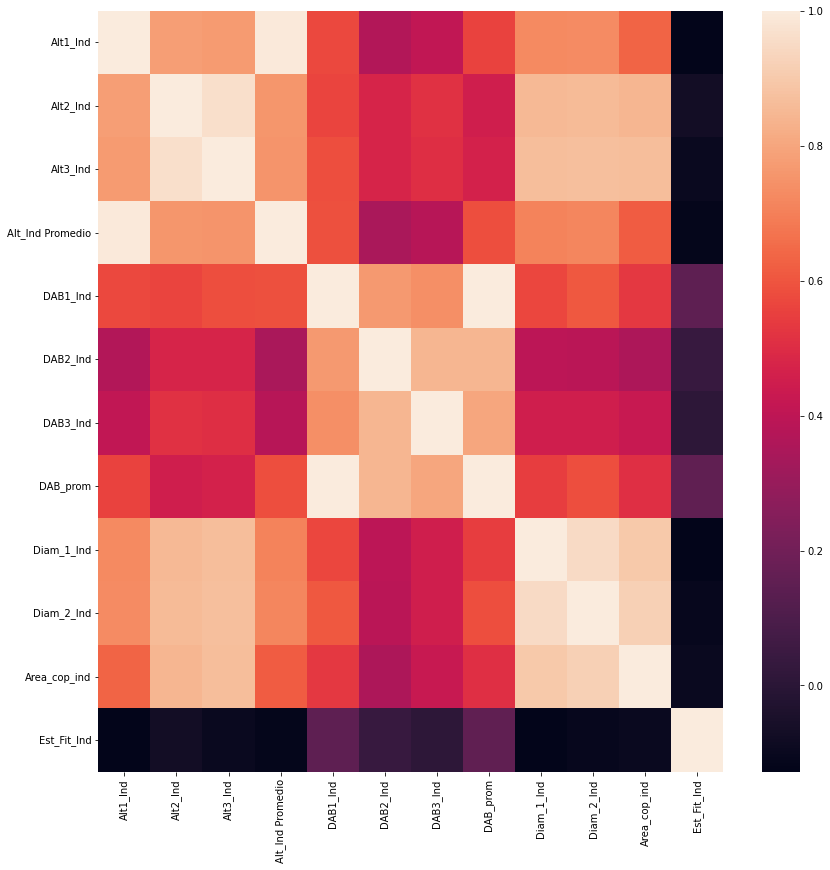

In [37]:
#let's see if any of the numeric columns can predict the others.
fig, ax = plt.subplots(figsize=(14,14))
num_cols = ['Alt1_Ind', 'Alt2_Ind', 'Alt3_Ind', 'Alt_Ind Promedio', 'DAB1_Ind', 'DAB2_Ind',
       'DAB3_Ind', 'DAB_prom', 'Diam_1_Ind', 'Diam_2_Ind', 'Area_cop_ind', 'Est_Fit_Ind']
data = reserve[num_cols]
ax = sns.heatmap(data.corr())

The dataset actually has a lot of related data. all the columns with 'promedio' or 'prom'
are averages of the columns they refer to. 'Area_cop_ind' is the product of the 'Diam' as you can
see above, there are 4 groups which can be simplified into the columns below:
Alt_Ind Promedio: The averaged height from the 3 height columns
DAB_prom: The averaged basal stem diameter
Area_cop_ind: The area of the two Diam columns, obtained with the folliwing formula:
Area = Diam A * Diam B / 2
Est_Fit_Ind: The presence of negative visual health indicators from 0-4. Lower is better.

In [40]:
# Grab all the numerical data from the dataset, also split into sample periods
quants = ['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']
num_reserve = reserve[quants]
r_num_dict = {}
for value in reserve['Even_mon'].unique():
    r_num_dict[value] = reserve[reserve['Even_mon'] == value]
    r_num_dict[value] = r_num_dict[value][quants]

Text(0.5, 1.0, 'Predictive Power of Quantitative Variables')

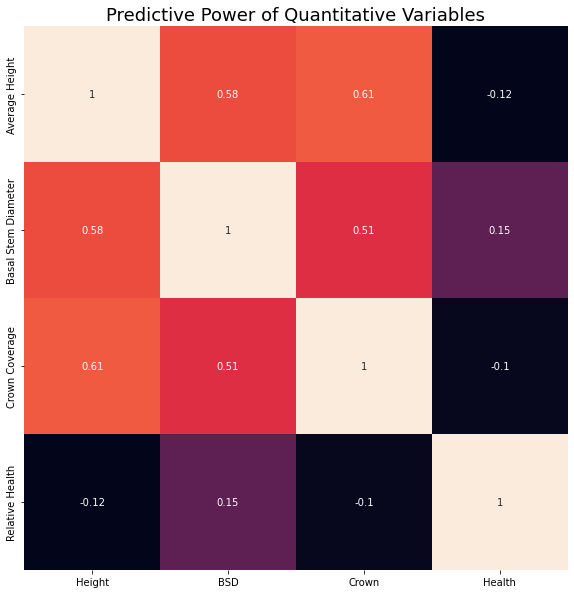

In [41]:
plt.figure(figsize = (20,10))
ylabels = ['Average Height', 'Basal Stem Diameter', 'Crown Coverage', 'Relative Health']
xlabels = ['Height', 'BSD', 'Crown', 'Health']
ax = sns.heatmap(num_reserve.corr(), 
                 annot=True, 
                 square=True, 
                 cbar=False, 
                 xticklabels=xlabels, 
                 yticklabels=ylabels)
sns.set_context('talk')
ax.set_title('Predictive Power of Quantitative Variables')

#plt.savefig(figures+'Correlaciones', dpi=600)
# Height is most correlated with crown area, then stem diameter. 
# Amazingly plant health may have a weak correlation with stem thickness.

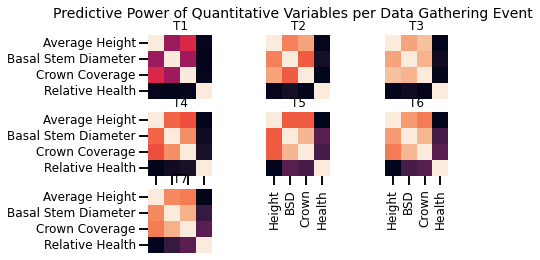

<Figure size 1440x1440 with 0 Axes>

In [42]:
fig, axs = plt.subplots(3,3)
plt.figure(figsize = (20, 20))
row = 0
col = 0
rep = 0
fig.suptitle('Predictive Power of Quantitative Variables per Data Gathering Event', fontsize=14)
for item in r_num_dict:
    if row == 1:
        x_labels = xlabels
    else:
        x_labels = []
    if col == 0:
        y_labels = ylabels
    else:
        y_labels = []
    sns.heatmap(r_num_dict[item].corr(), 
                ax=axs[row, col], 
                annot=False, 
                square=True, 
                cbar=False, 
                xticklabels=x_labels, 
                yticklabels=y_labels
               )
    axs[row, col].set_title(item, fontsize=12)
    axs[row, col].set_xticklabels(x_labels, fontsize=12)
    axs[row, col].set_yticklabels(y_labels, fontsize=12)
    if rep == 2 or rep == 5:
        col = 0
        row += 1
    else:
        col += 1
    rep += 1
fig.delaxes(axs[2,1])  
fig.delaxes(axs[2,2])  

#fig.savefig(figures+'Correlaciones_por_monitoreo', dpi=600, bbox_inches='tight')
# T1 has the weakest correlation. If we excluded T1 from the aggregate Principal Component Analysis we would actually get
# much stronger correlations.
# This breakdown on the other hand weakens the plant health/stem thickness correlation.

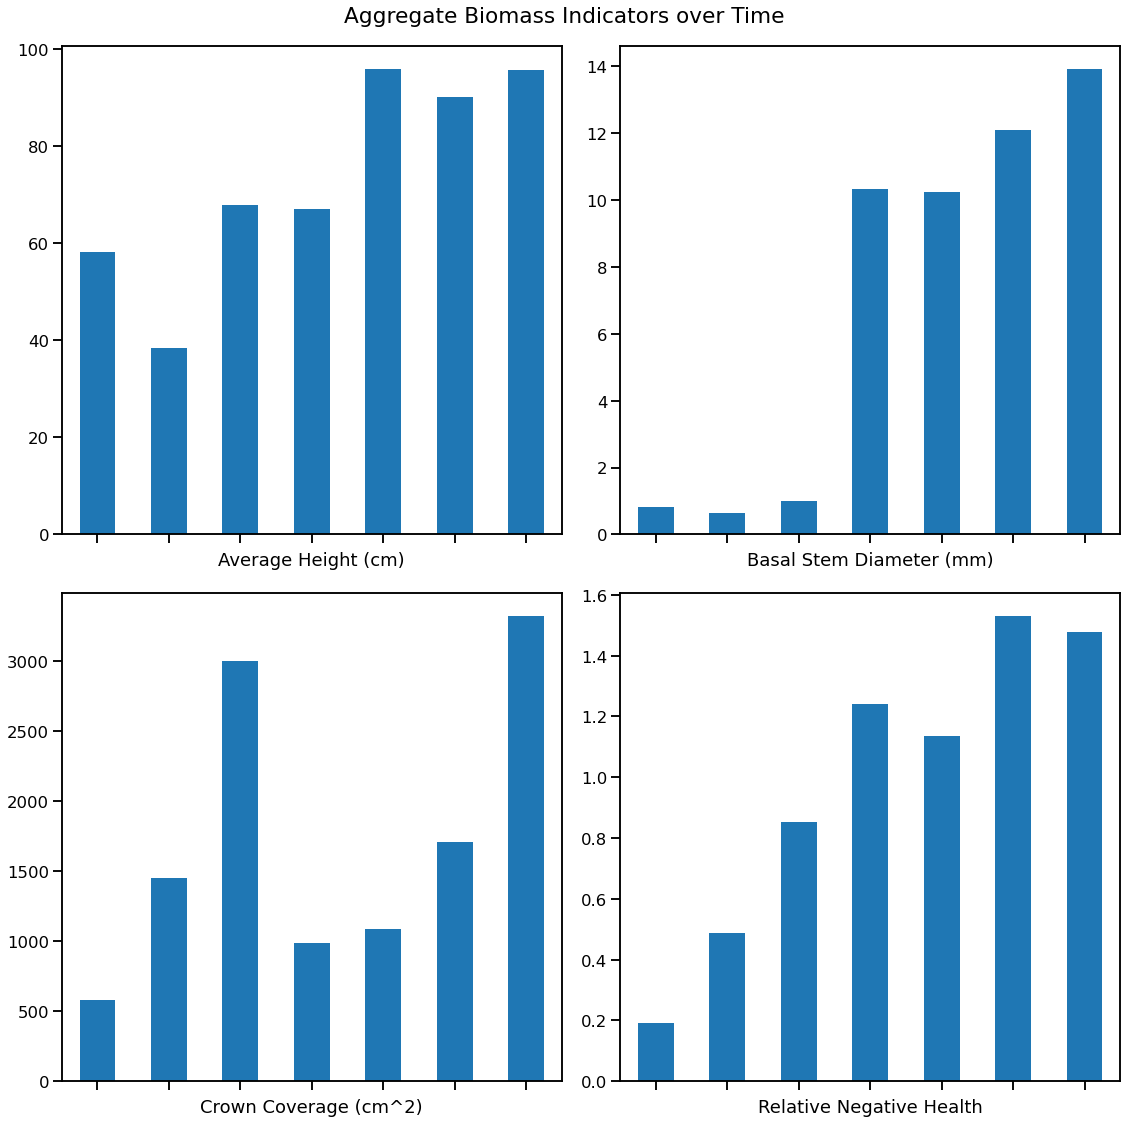

In [43]:
# Now to plot the performance of these 4 main columns over time.
biomass_values = {'Alt_Ind Promedio': 'Average Height (cm)', 
                  'DAB_prom': 'Basal Stem Diameter (mm)', 
                  'Area_cop_ind': 'Crown Coverage (cm^2)', 
                  'Est_Fit_Ind': 'Relative Negative Health'}
variables = ['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']
biomass = reserve.groupby('Even_mon')[variables].mean()
fig, ax = plt.subplots(2, 2, figsize=(16,16))
row = 0
col = 0
rep = 0
for var in variables:
    data = biomass[var]
    data.plot.bar(ax=ax[row, col])
    ax[row, col].set_xlabel(biomass_values[var])
    ax[row, col].set_xticklabels([])
    if rep == 1:
        col = 0
        row += 1
    else:
        col += 1
    rep += 1
fig.suptitle('Aggregate Biomass Indicators over Time')
fig.tight_layout()
#fig.savefig(figures+'Fig01 Aggregate Biomass Indicators over Time', dpi=600, transparent=True)
#Generally speaking, the plants are successfully growing over time, but health is deteriorating.

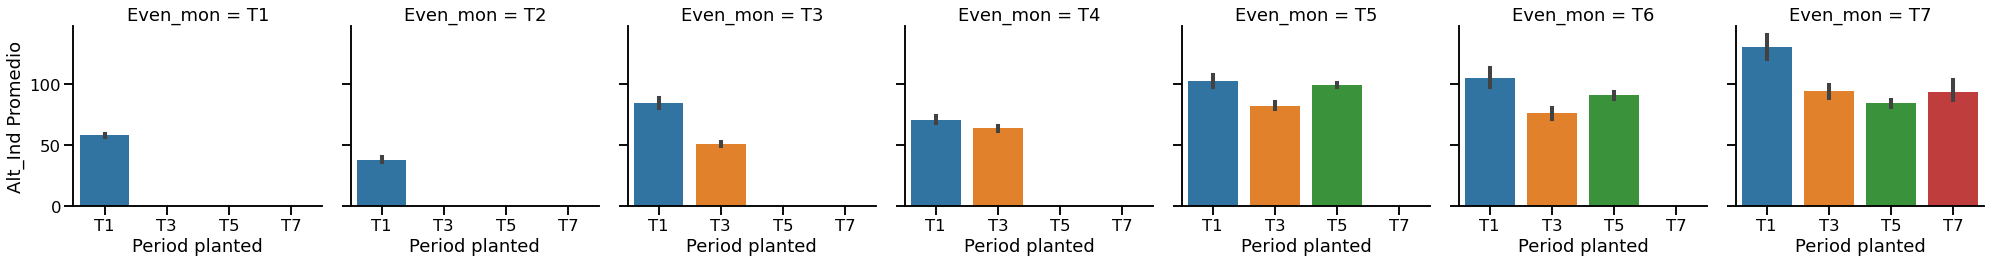

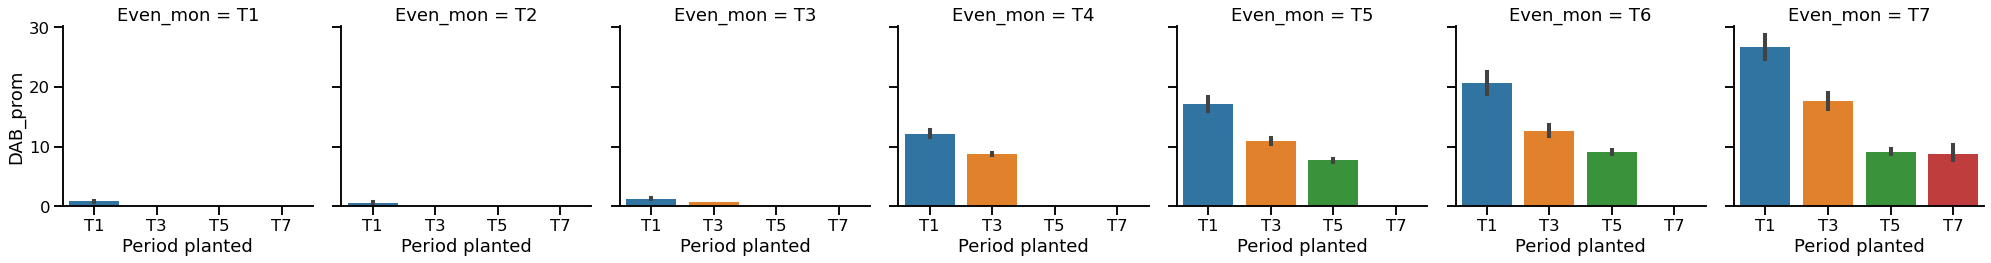

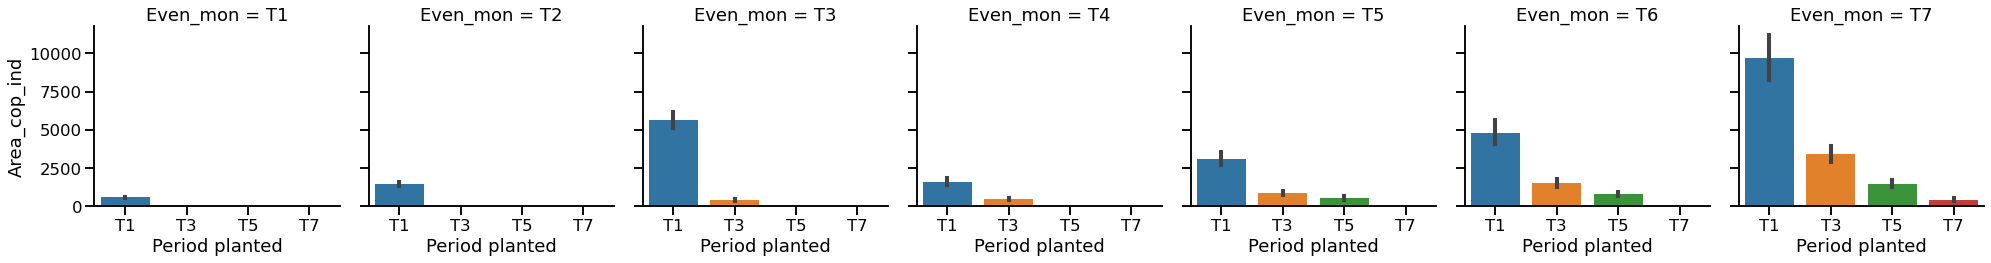

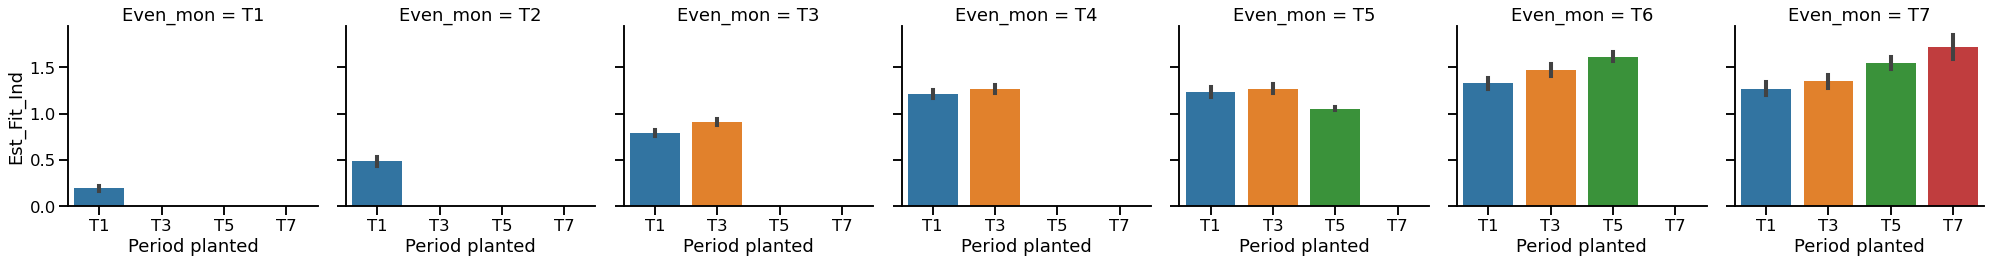

In [44]:
for var in variables:
    g = sns.FacetGrid(reserve, col='Even_mon', hue='Period planted', height=4)
    g.map(sns.barplot, "Period planted", var, order=['T1', 'T3', 'T5', 'T7'])
    
# This further details what was shown before.
# Between T5 and T6, there was a reduction in height in the younger T3 and T5 plants
# and an increase in negative plant health effects across the board.
# T5 plants were planted tall and skinny, which may have negative effects.

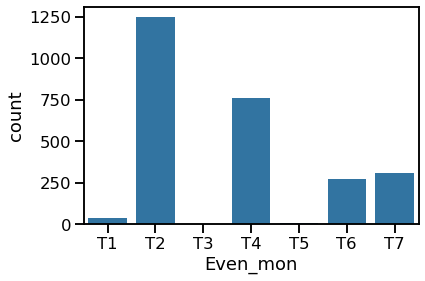

In [45]:
# Now we can look at plant mortality over time
dead = reserve.loc[reserve['Sup_Ind'] == False]
events = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
sns.countplot(x='Even_mon', data=dead, order=events, color='tab:blue');
# This shows an increase in plant survival over time.

In [46]:
# The seemingly linear trend of dead  plants makes me wonder if there's a pattern. 
# Are we simply getting fewer deaths because mortality is highest among young plants, 
# and so the dead is actually mostly selected from the replacements?
# Or is the number of dead being selected in large enough amounts from older plants as well?

Total_plants = 2751
T2_dead = 1248
T4_dead = 764
T6_dead = 270
dead_ratio1 = T2_dead/Total_plants
dead_ratio2 = T4_dead/T2_dead
dead_ratio3 = T6_dead/T4_dead

print(dead_ratio1, ' : ', dead_ratio2, ' : ', dead_ratio3)

# If mortality was mostly determined by the amount of young plants, we would expect to see very similar ratios
# Instead it seems like there are other determining factors, and our second re-plant was the least successful.

0.4536532170119956  :  0.6121794871794872  :  0.35340314136125656


In [47]:
# Finally, which plants are dying the most? Is it older or younger plants?
groups = ['Even_mon', 'Period planted', 'Sup_Ind']
survival_distributions = reserve.groupby(groups)['ID'].count().reset_index()
survival_distributions

,Even_mon,Period planted,Sup_Ind,ID
0,T1,T1,False,37
1,T1,T1,True,2714
2,T2,T1,False,1248
3,T2,T1,True,1503
4,T3,T1,True,1363
5,T3,T3,True,1388
6,T4,T1,False,467
7,T4,T1,True,896
8,T4,T3,False,297
9,T4,T3,True,1091


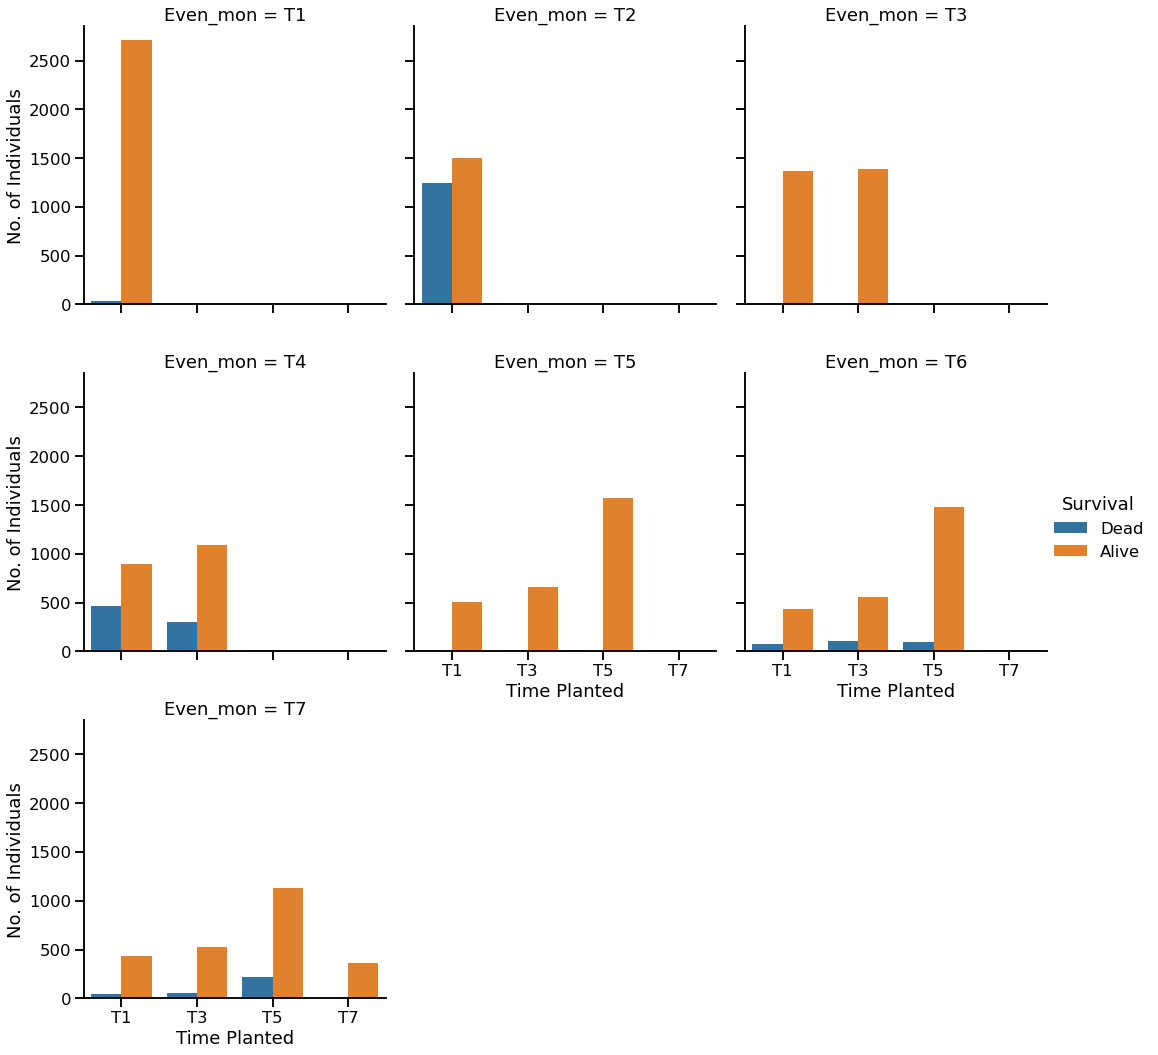

In [48]:
fig = sns.catplot(x='Period planted',
                  y="ID", 
                  hue="Sup_Ind", 
                  col='Even_mon', 
                  col_wrap=3, 
                  data=survival_distributions, 
                  kind='bar')
fig.set_axis_labels('Time Planted', 'No. of Individuals')
fig._legend.set_title('Survival')
for t, l, in zip(fig._legend.texts, ['Dead','Alive']):
    t.set_text(l)
# This chart would imply that other than the first mortality event in T2, mortality is being kept 
# relatively low.
# However, the amount of plants that were added in T5 does not account for the amount of dead in T4
# We shall have to see how it continues over time.

In [49]:
# This is how I got the values for the next plot
for value in reserve['Even_mon'].unique():
    print(reserve[reserve['Even_mon'] == value]['Period planted'].value_counts())

T1    2751
Name: Period planted, dtype: int64
T1    2751
Name: Period planted, dtype: int64
T3    1388
T1    1363
Name: Period planted, dtype: int64
T3    1388
T1    1363
Name: Period planted, dtype: int64
T5    1576
T3     664
T1     511
Name: Period planted, dtype: int64
T5    1576
T3     664
T1     511
Name: Period planted, dtype: int64
T5    1342
T3     576
T1     475
T7     358
Name: Period planted, dtype: int64


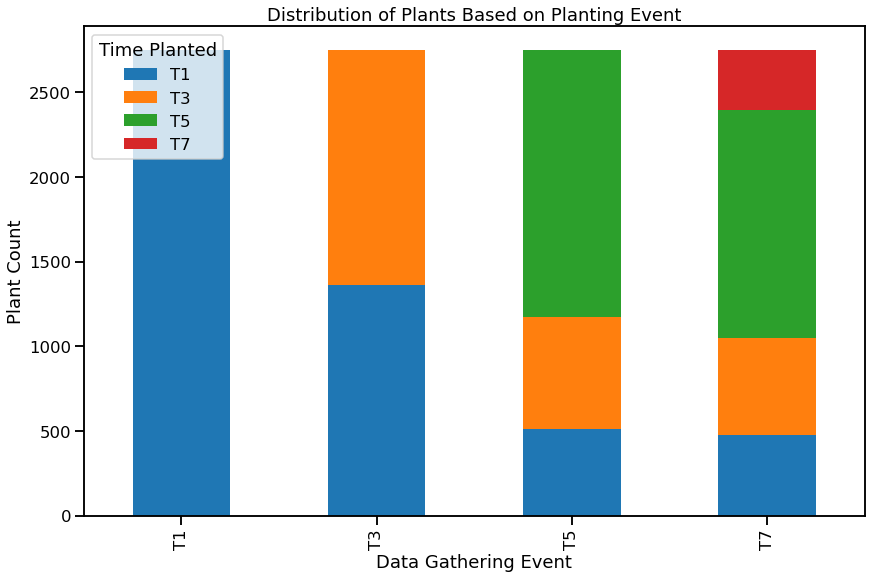

In [50]:
# This shows a very high mortality overall, but low for the T3 replanting event.
index = ['T1', 'T3', 'T5', 'T7']
T1 = [2751, 1363, 511, 475]
T3 = [0, 1388, 664, 576]
T5 = [0, 0, 1576, 1342]
T7 = [0, 0, 0, 358]


demographic_pop = pd.DataFrame({'T1': T1, 'T3':T3, 'T5':T5, 'T7':T7}, index=index)
ax = demographic_pop.plot.bar(stacked=True, figsize=(14,9))
ax.set_title('Distribution of Plants Based on Planting Event')
ax.set_xlabel('Data Gathering Event')
ax.set_ylabel('Plant Count')
ax.legend(title='Time Planted');



QUESTION 1 RECAP 
On average, the indicators for plant growth (Height, Stem Diameter, Crown Area) are increasing
over time for all cohorts. Plant mortality is however, consistently high for new plants, 
ranging between 40-60% of total plants. 
There appears to be a cutoff point after which plant mortality drops significantly.
While it can be assumed that plant health remains within acceptable parameters in surviving plants,
the factors which affect them appear to constantly be increasing over time. Whether this is a
measurement error or a trend which has yet to conclude will become clearer over time.

QUESTION 2: Is the project succeeding ecologically?
    - Plant health is a general indicator of its interaction with local conditions.
    - You expect to see some negative health effects but not enough that it causes undue mortality.
    - We already know young plants die early, here we find out why.

To determine plant health we used two criteria:
1 - An affectation index from 0-4 covering the percentage of the plant displaying negative health traits

2 - A boolean indication of which types of afectation are visible on the plant. These are as follows:
    Coloracion - Coloration. Any off-coloring of a plant is noted here
    Vigor bajo - Low vigor. General malaise and especially lack of turgor in the leaf parts.
    Herbivoria - Herbivory. Consumption of leaf tissue by insects or animals.
    Patogenos - Pathogens. Evidence of disease caused by microorganisms
    Competencia - Competition. Crowding or strangulation by exotic species.
    Daño mecanico - Mechanical damage. Any breaks and tears not caused by the above.
    Anegamiento - Waterlogging. The presence of visible water in the area occupied by the plant root system.
    Daño por Curi - Guinea pig damage. This one was added later as a response to a specific issue we were facing.
    Helada - Frost damage. the majority of the mortality in T2 is attributed to a flash freeze, but was not tracked at the time.
Together these two factors give a rough estimate of the overall health of a plant as well as clues to what was causing the malaise.


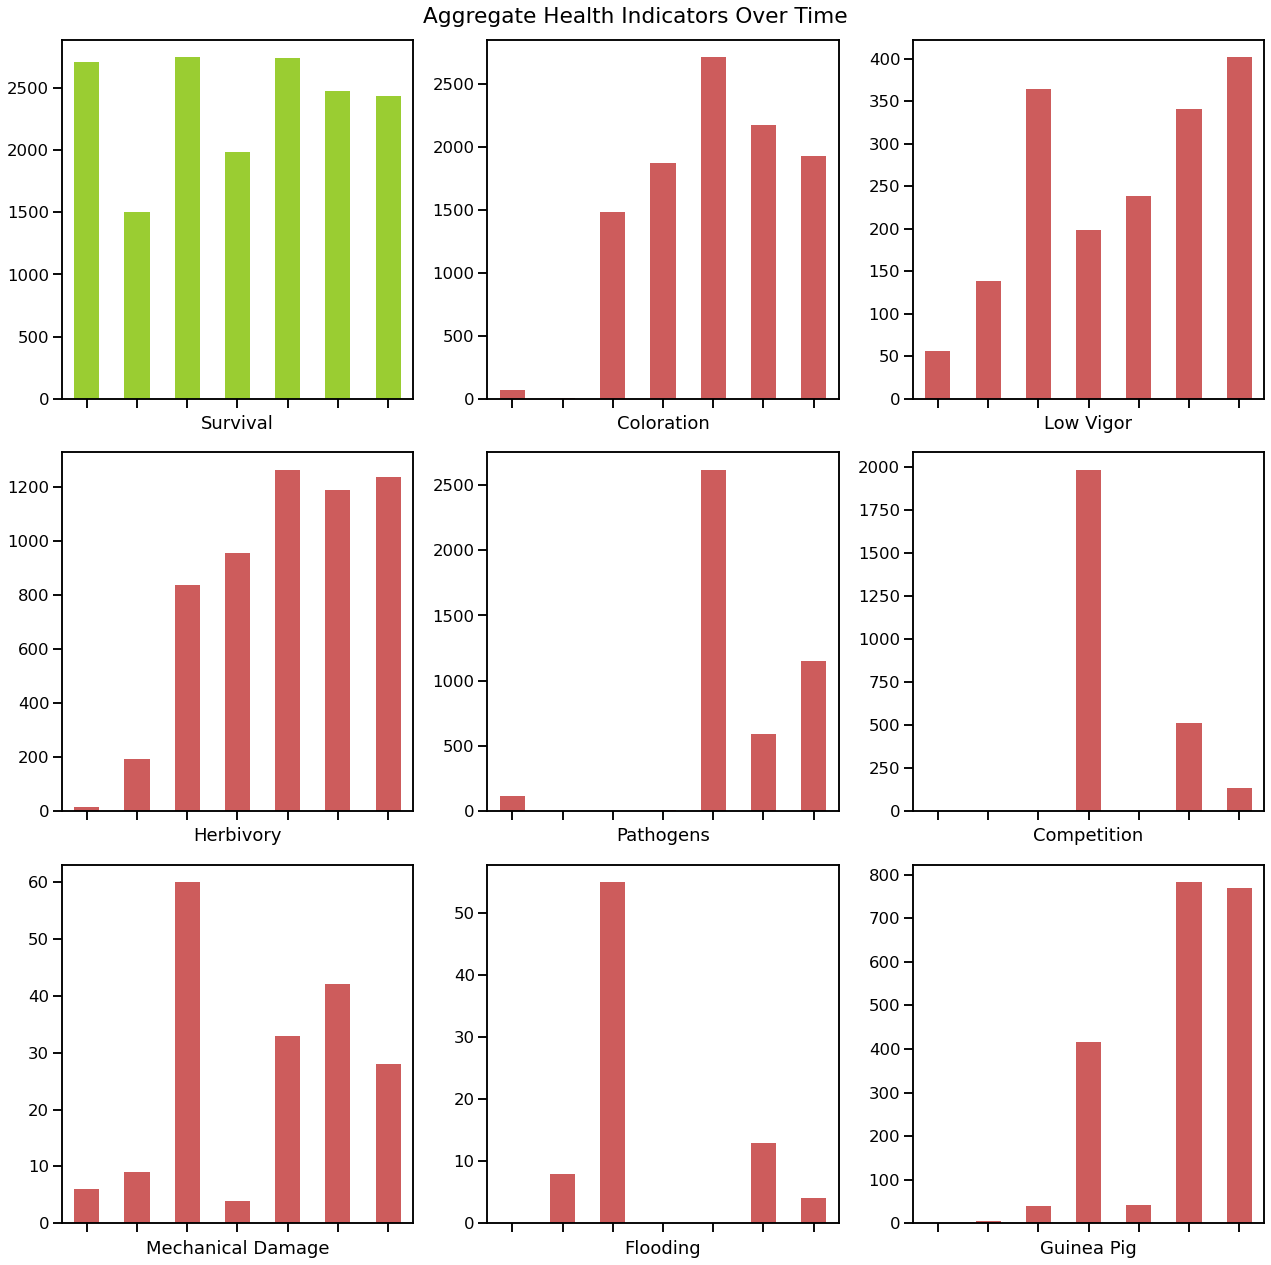

In [51]:
# Here we plot the types of affectations over time.
affectations_over_time = reserve.groupby('Even_mon')[affectations].sum()
aff_dict = {'Sup_Ind' : 'Survival',
 'Coloracion': 'Coloration',
 'Vigor bajo': 'Low Vigor',
 'Herbivoria': 'Herbivory',
 'Patogenos': 'Pathogens',
 'Competencia': 'Competition',
 'Daño mecanico': 'Mechanical Damage',
 'Anegamiento': 'Flooding',
 'Daño por Curi': 'Guinea Pig'}
fig, ax = plt.subplots(3, 3, figsize=(18, 18))
row = 0
col = 0
rep = 0
for aff in affectations:
    data = affectations_over_time[aff]
    if row == 0 and col == 0:
        color = 'yellowgreen'
    else:
        color = 'indianred'
    data.plot.bar(ax=ax[row, col], color=color)
    ax[row, col].set_xticklabels([])
    ax[row, col].set_xlabel(aff_dict[aff])
    if rep == 2 or rep == 5:
        col = 0
        row += 1
    else:
        col += 1
    rep += 1
fig.suptitle('Aggregate Health Indicators Over Time')
fig.tight_layout()
fig.savefig(figures+'Fig02 Aggregate Health Indicators Over Time', dpi=600, transparent=True)

# Here patterns vary significantly.  Generally speaking survival increases over time,
# but so do negative health effects. Some, like Pathogens and Competition, don't seem to have
# a trend. We will likely learn more by examining the trends that are more stable.

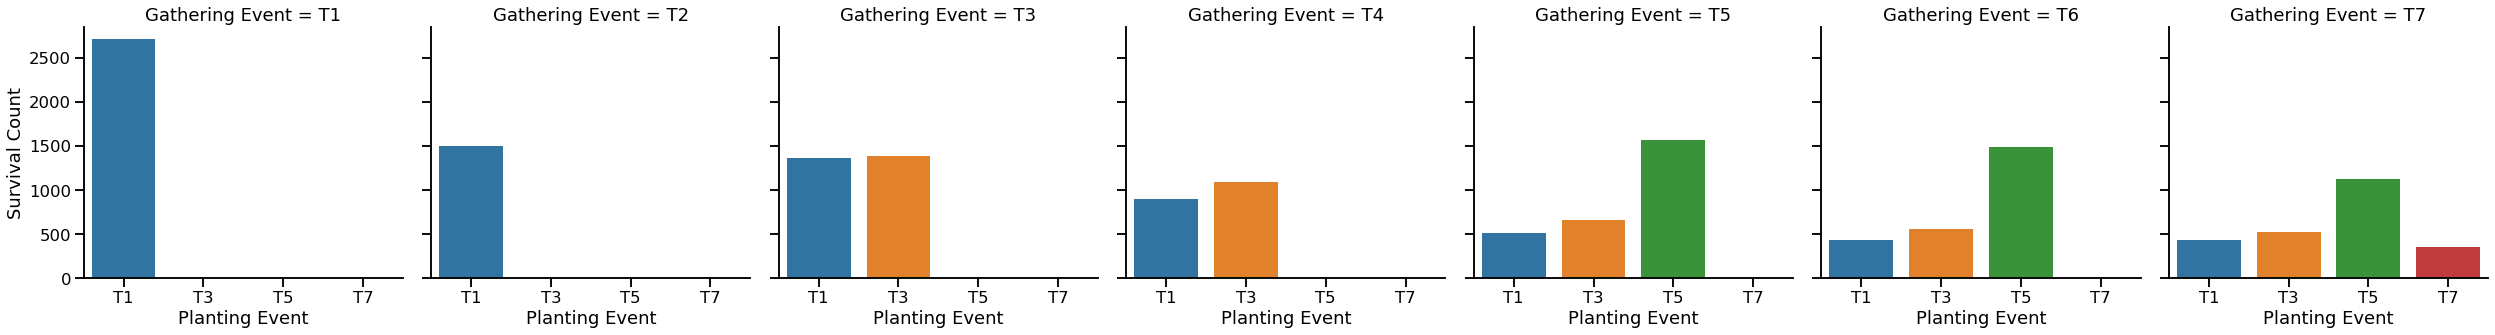

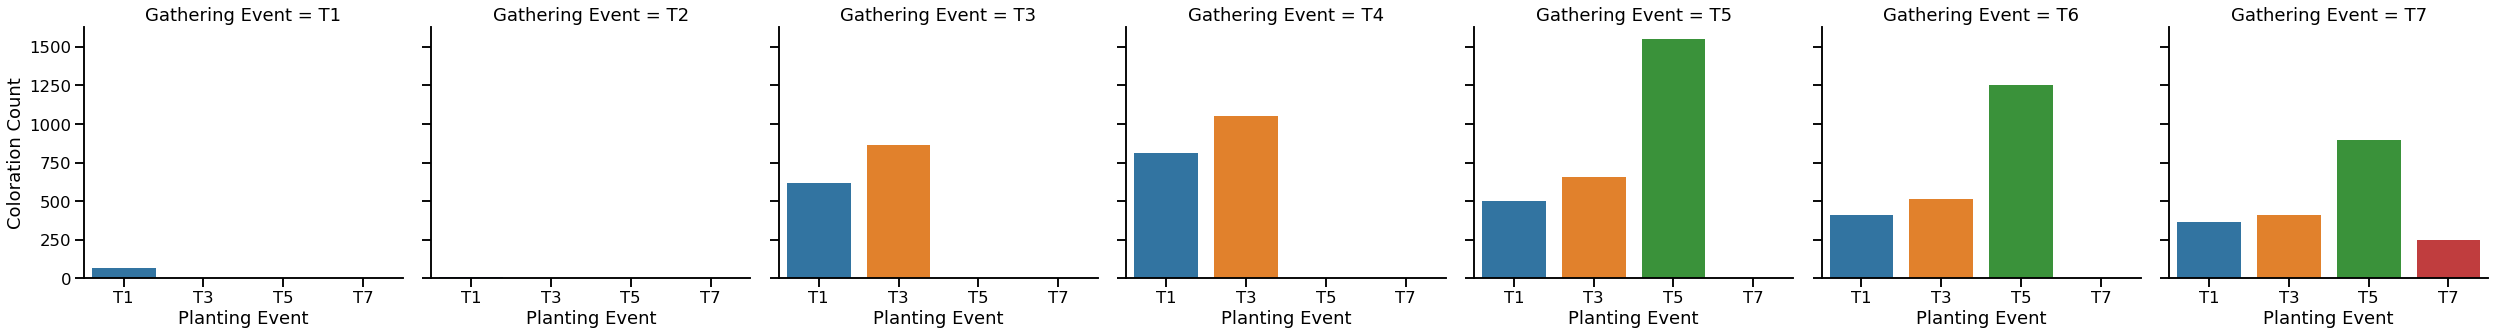

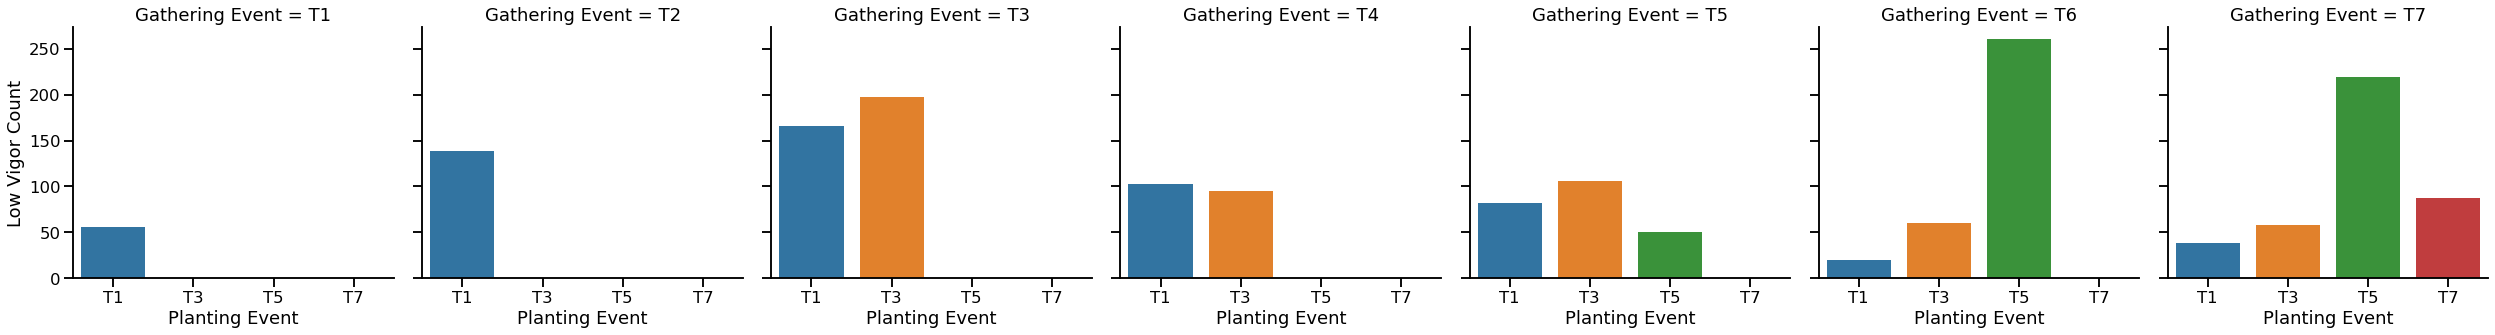

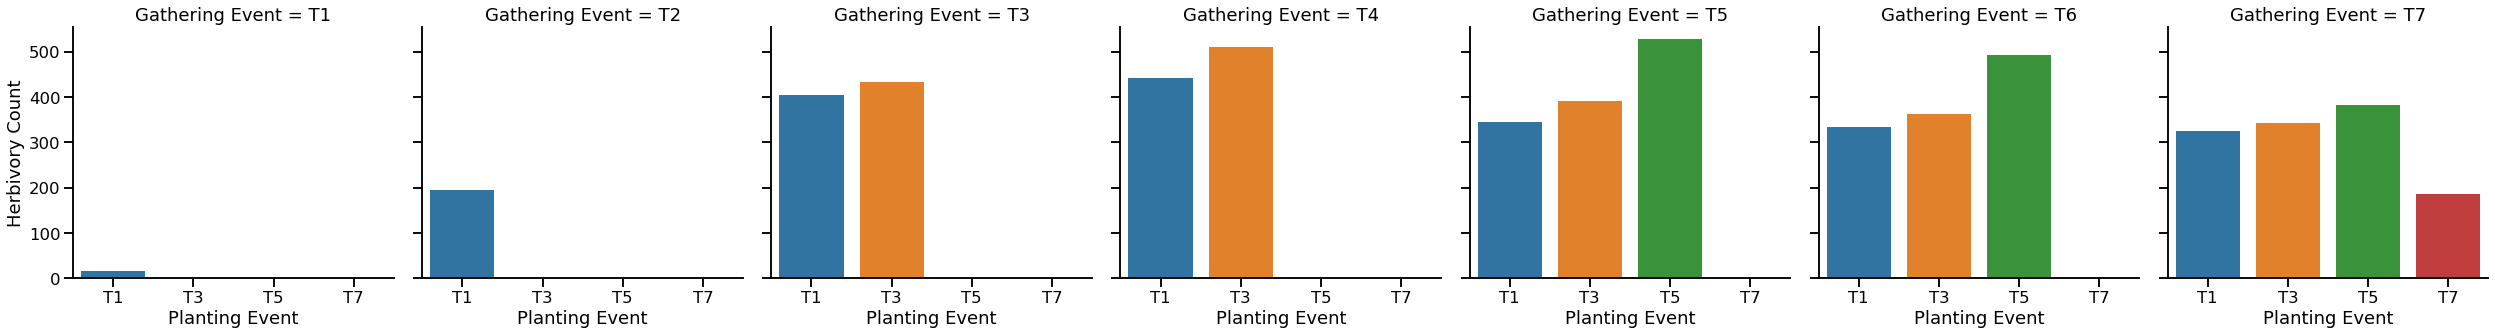

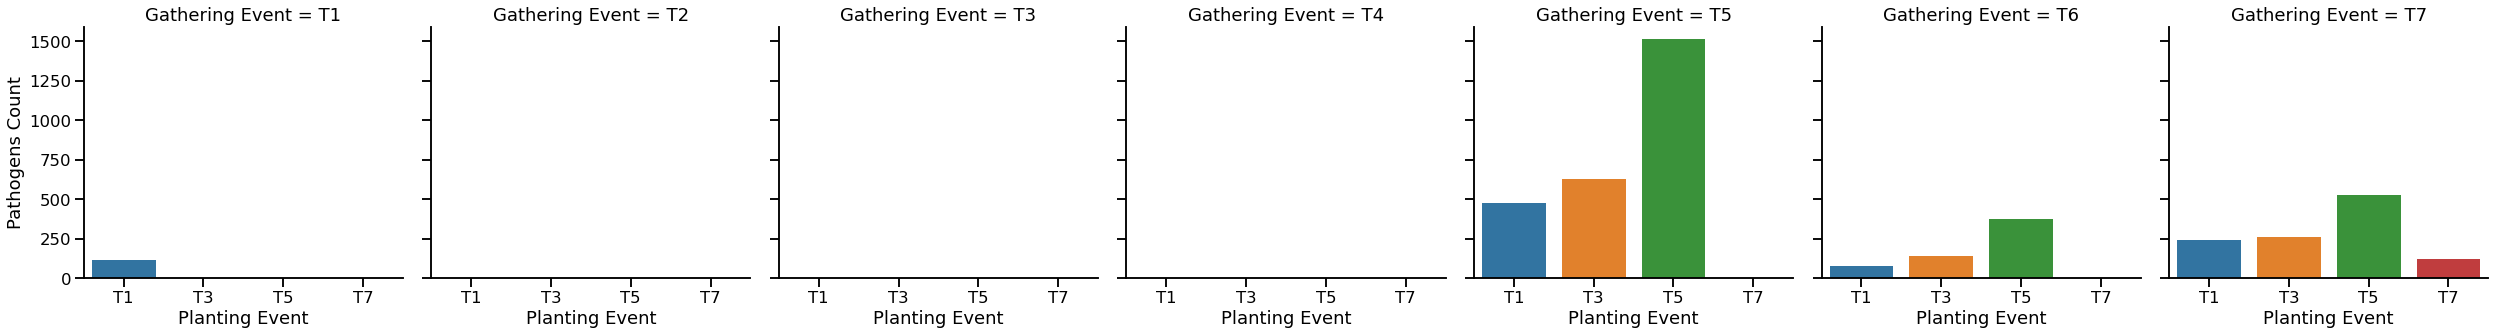

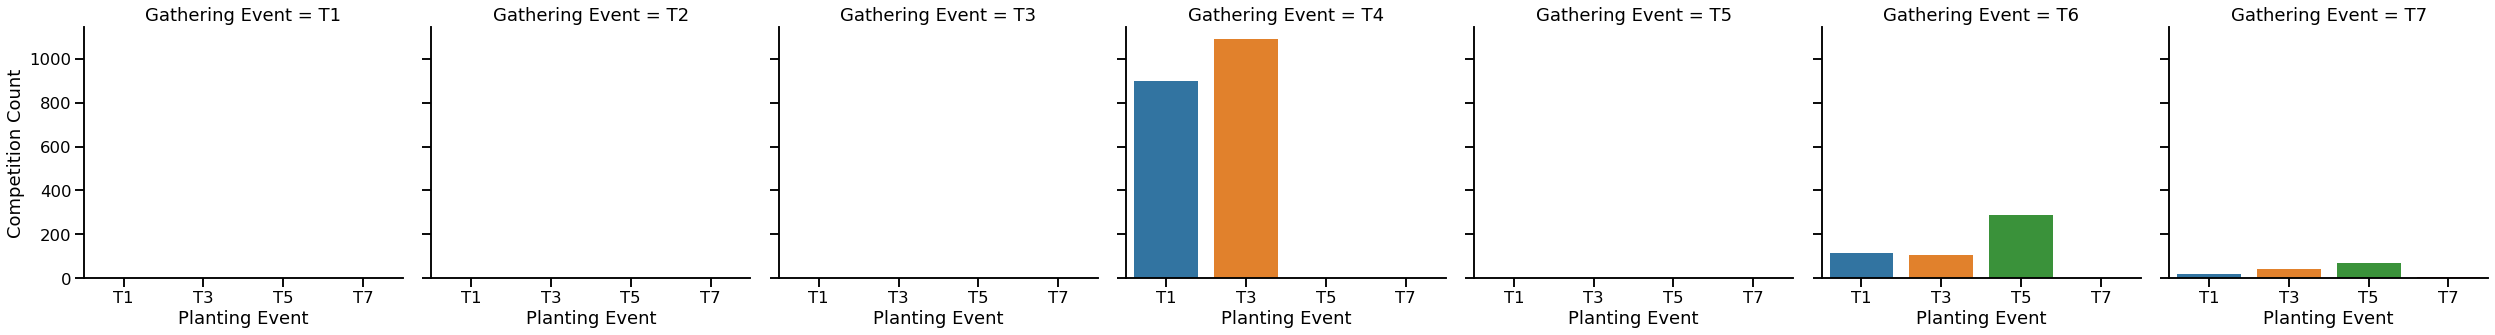

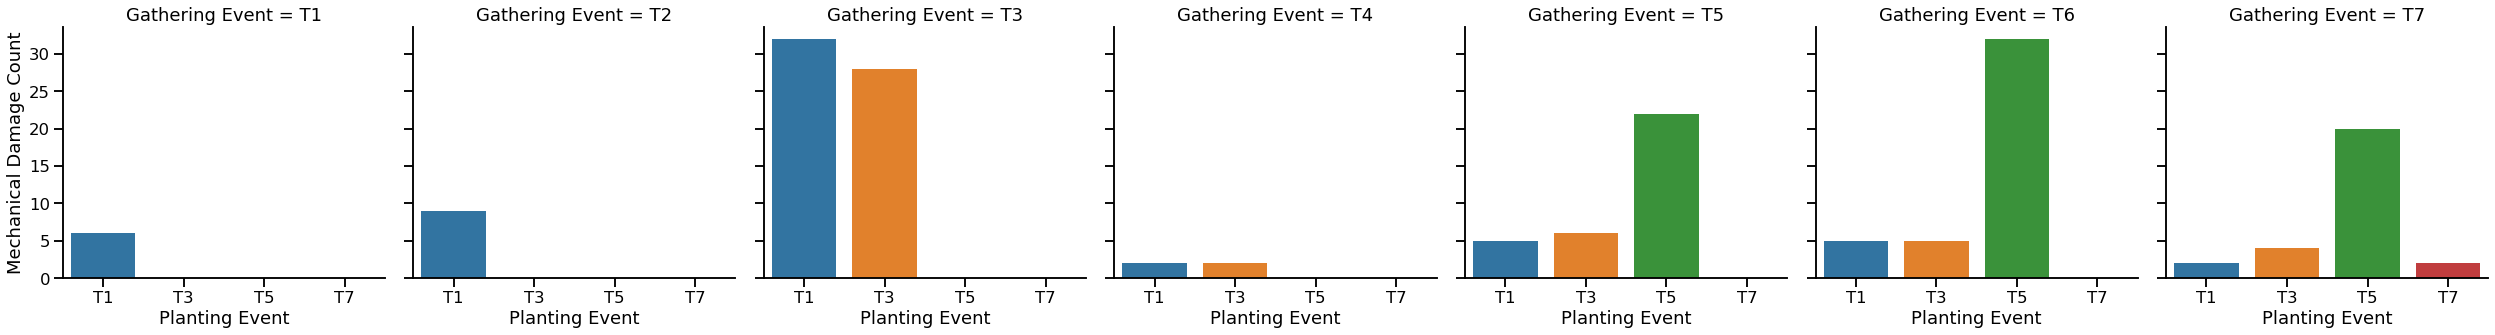

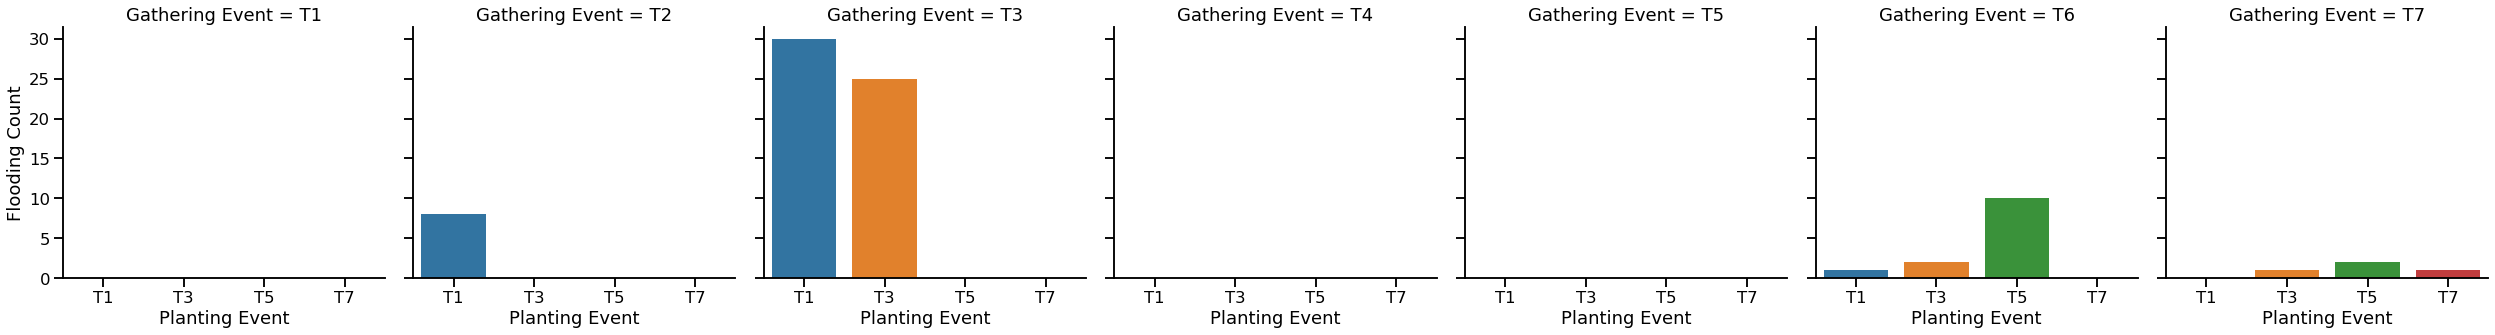

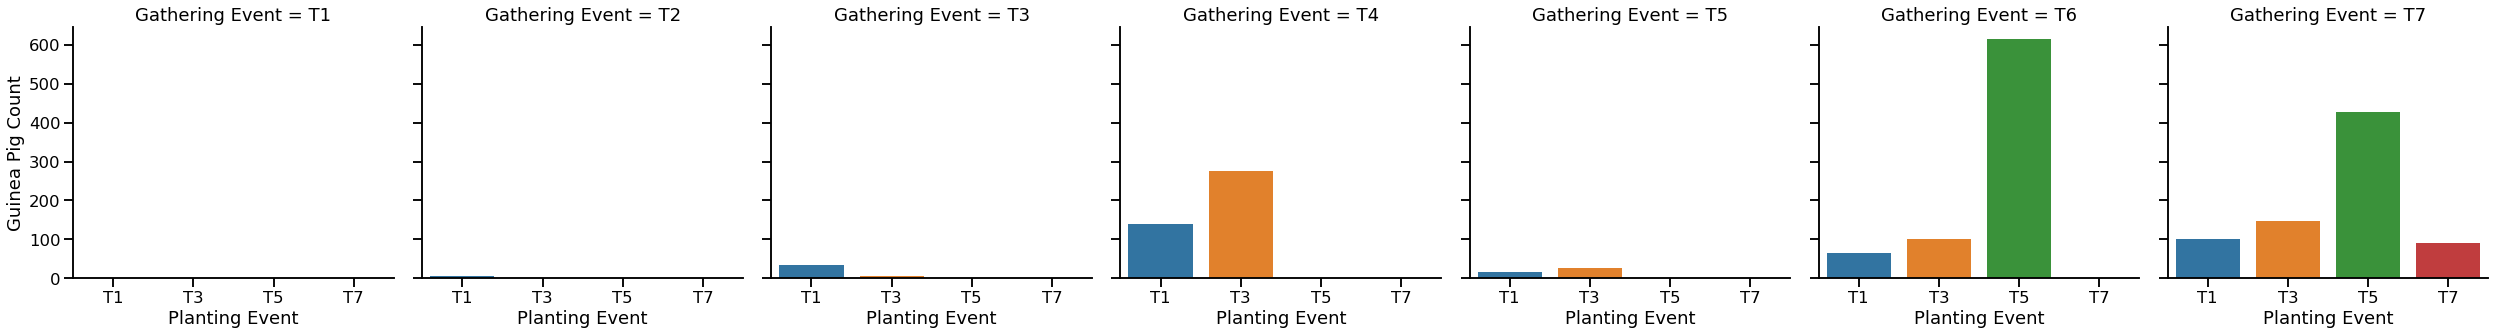

In [52]:
affectations_per_period = reserve.groupby(['Even_mon', 'Period planted'])[affectations].sum().reset_index()
affectations_per_period.rename(columns={'Even_mon':'Gathering Event'}, inplace=True)
for aff in affectations:
    fig = sns.catplot(x="Period planted", 
                      y=aff, 
                      hue="Period planted", 
                      col='Gathering Event', 
                      data=affectations_per_period, 
                      kind='bar', 
                      dodge=False)
    fig.set_axis_labels('Planting Event', f'{aff_dict[aff]} Count')

        
# It's unknown if the T1 plants were healthier at the beginning or if we simply changed our
# sample methods

# Starting from T2 it appears that internal plant factors like Coloration stay steady
# or decrease slightly over time

# Younger plants seem to suffer more from Low Vigor which will then decrease over time

# Herbivory seems to be fairly constant, which would make sense if the animals in question 
# maintained steady populations

# Pathogens seem to have been measured mostly in T5 and affected younger plants disproportionately. 
# Is this sampling error?

# Competition from exotic species seems to have been poorly tracked overall. 
# The spike in T4 was due to a lack of cutting the grass.

# Mechanical damage also seems inconsistently tracked. 
# It does however seem to affect younger plants more.

# Waterlogging seems to be a periodic issue and not one that affects plants in a 
# particularly strong fashion

# Previously the damage from Guinea Pigs was measured as Herbivory until T6, 
# and is possibly counted twice in T6. They seem to favor the young plants.


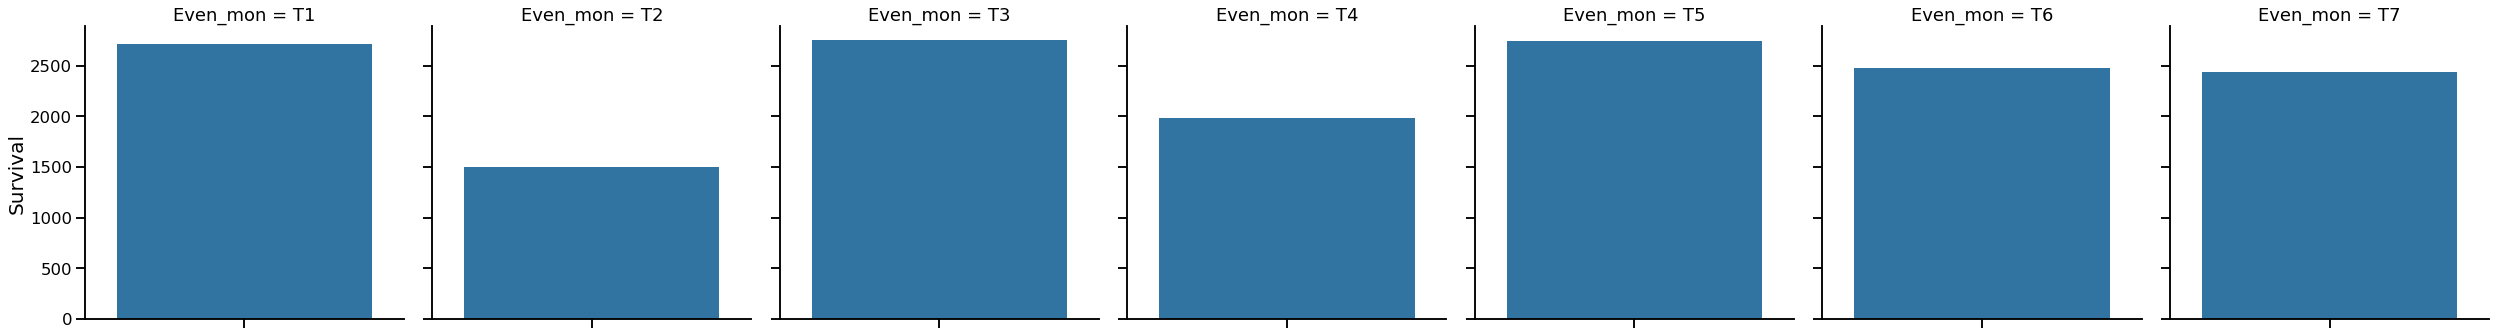

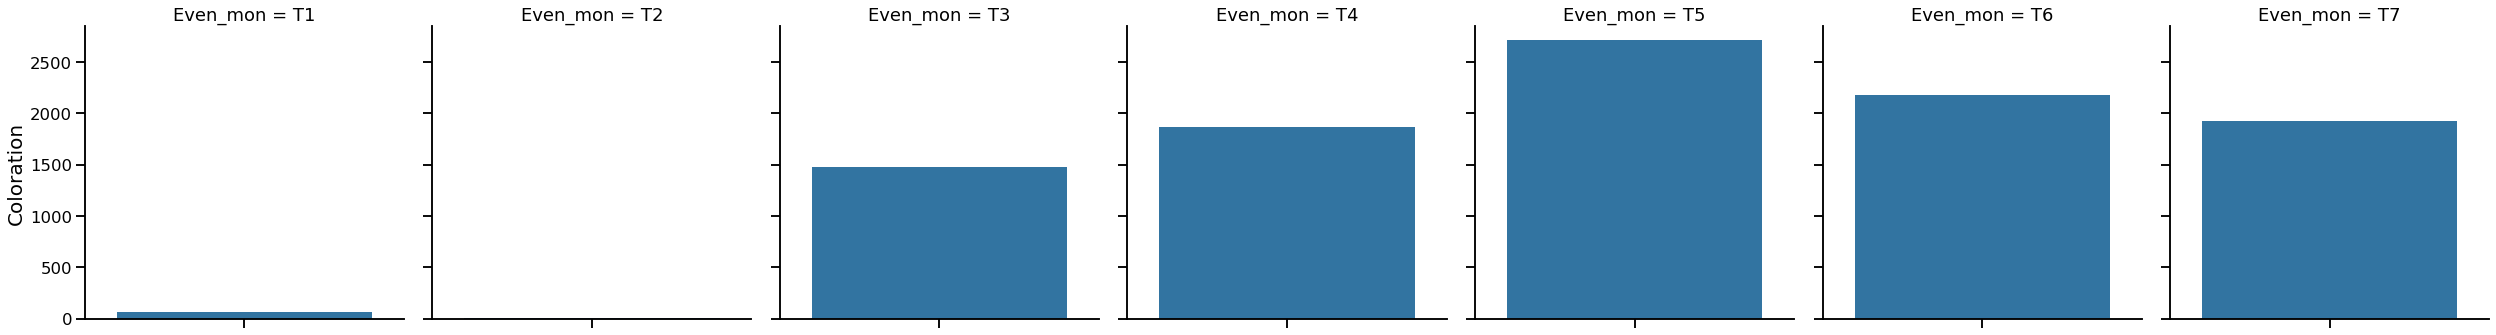

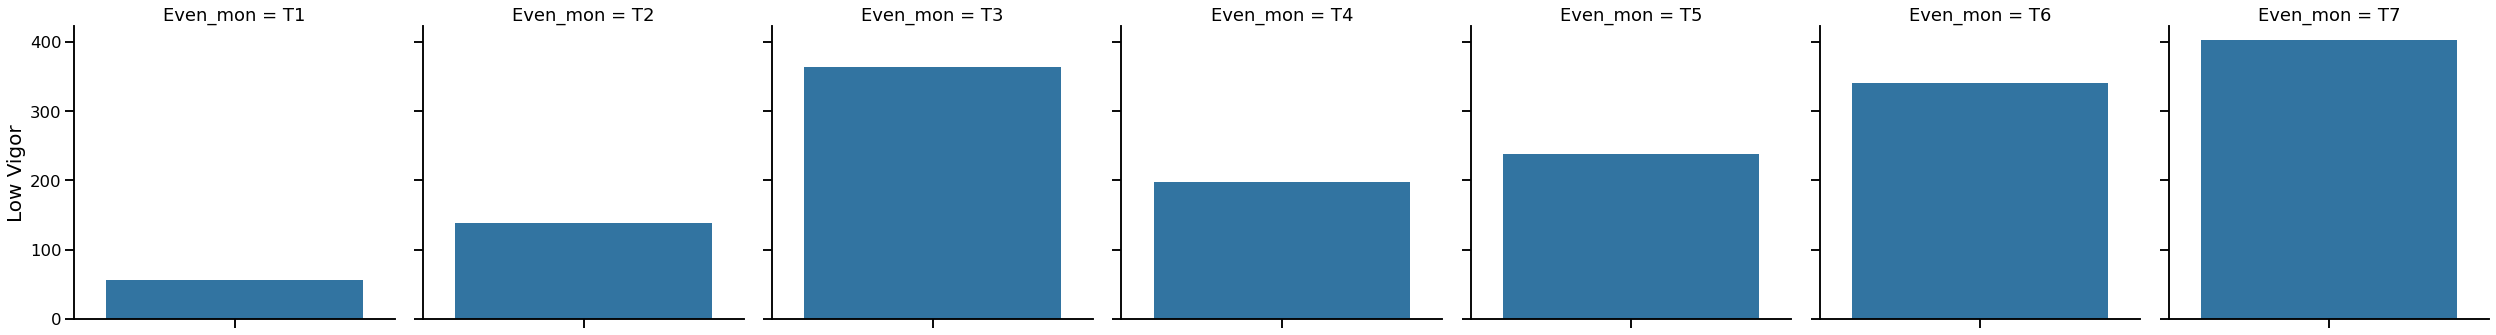

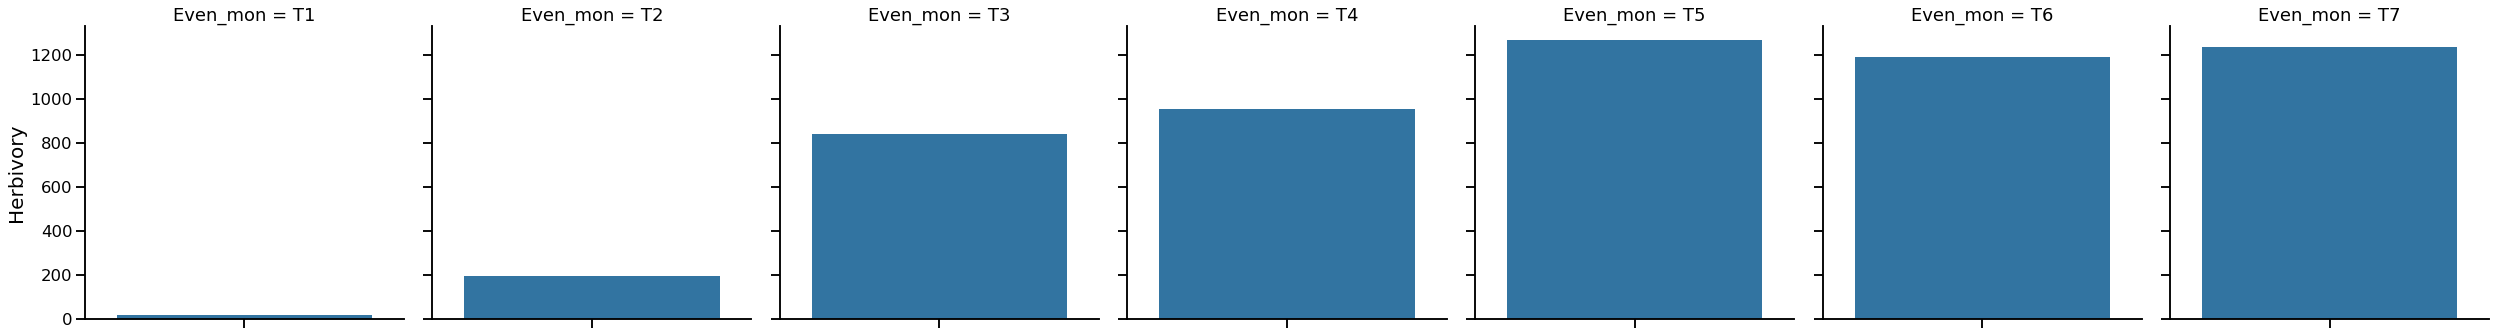

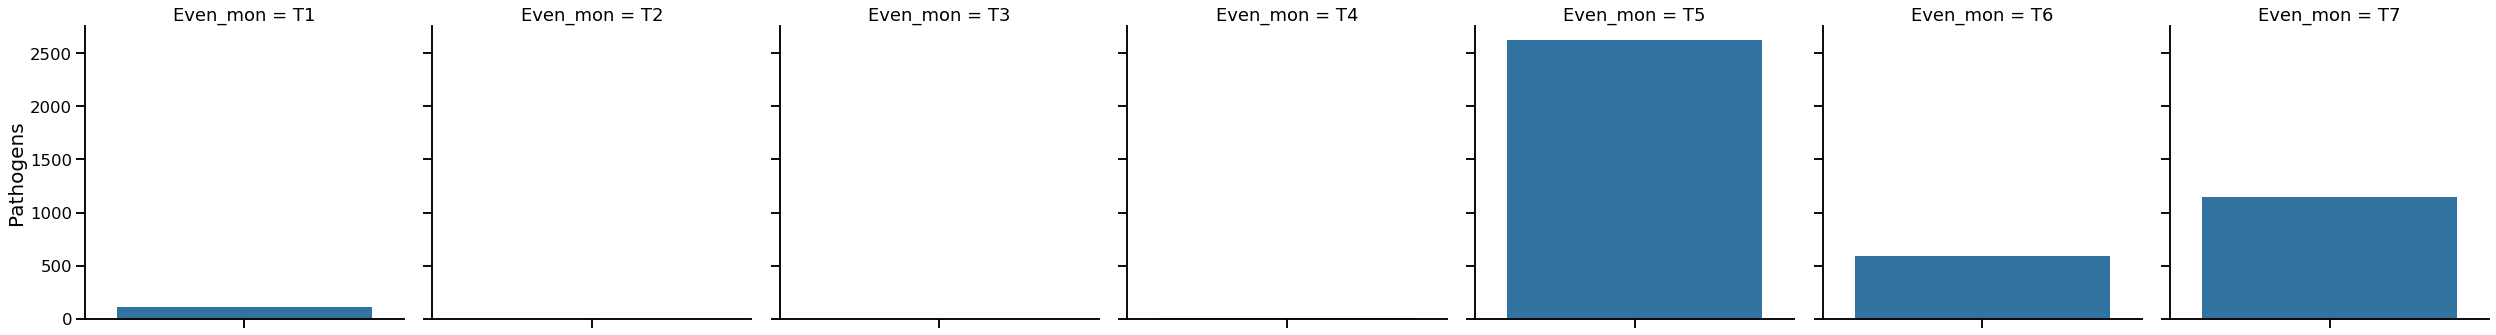

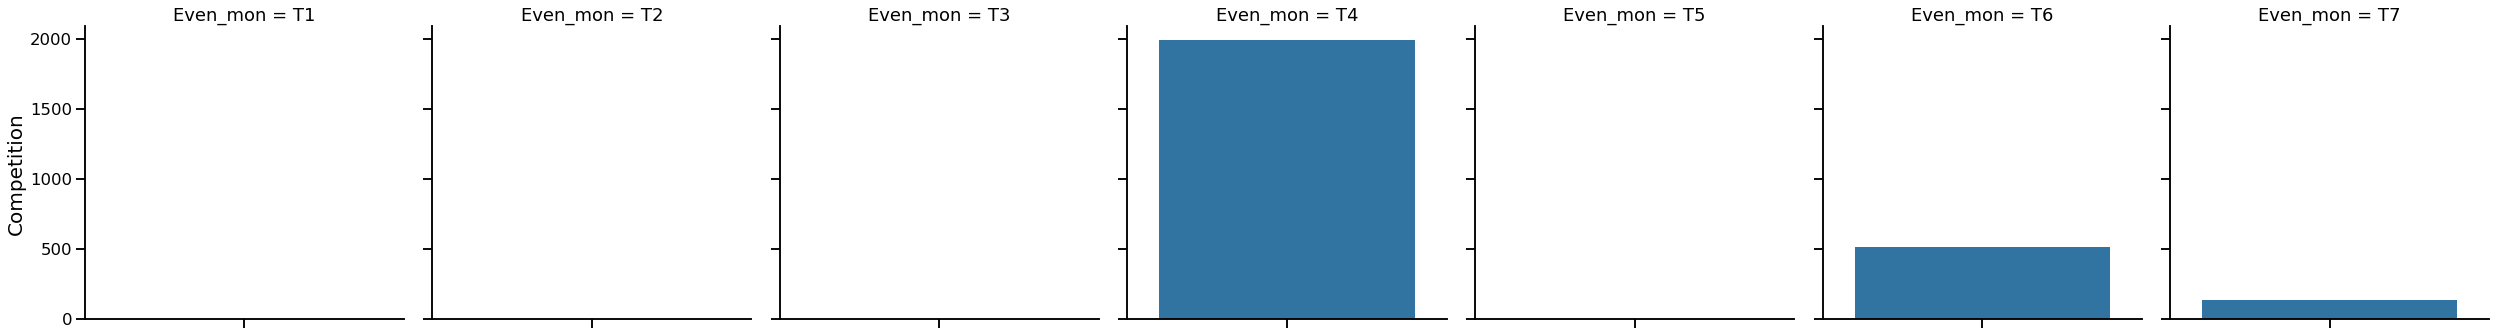

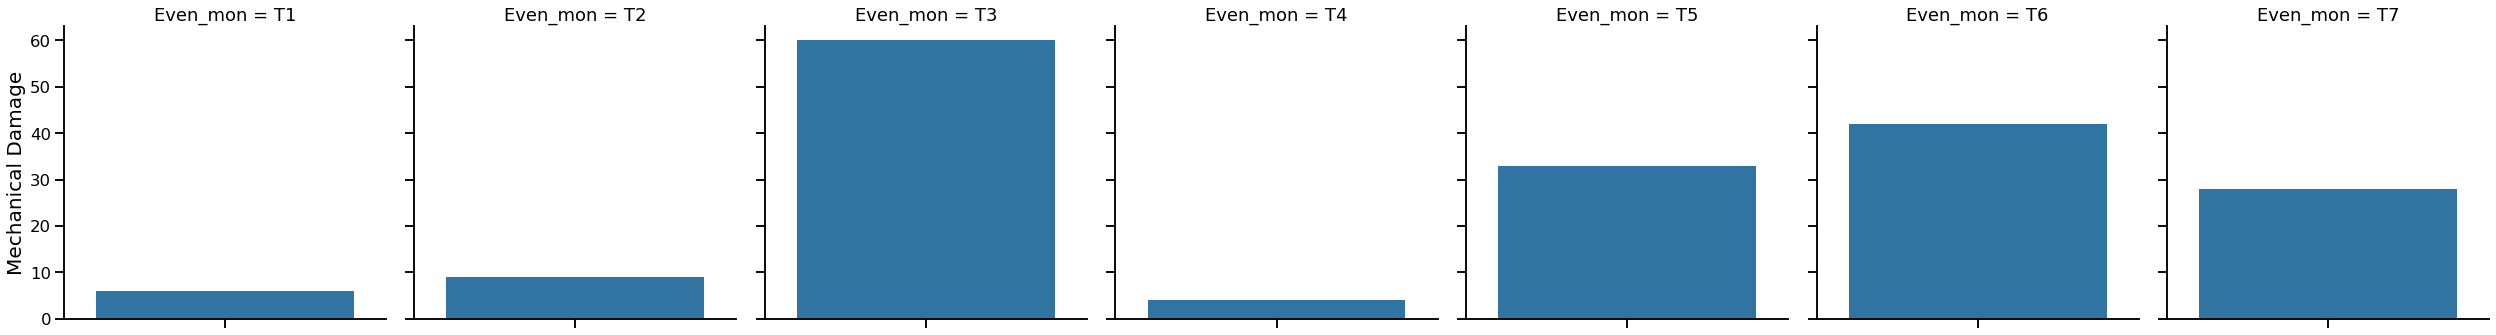

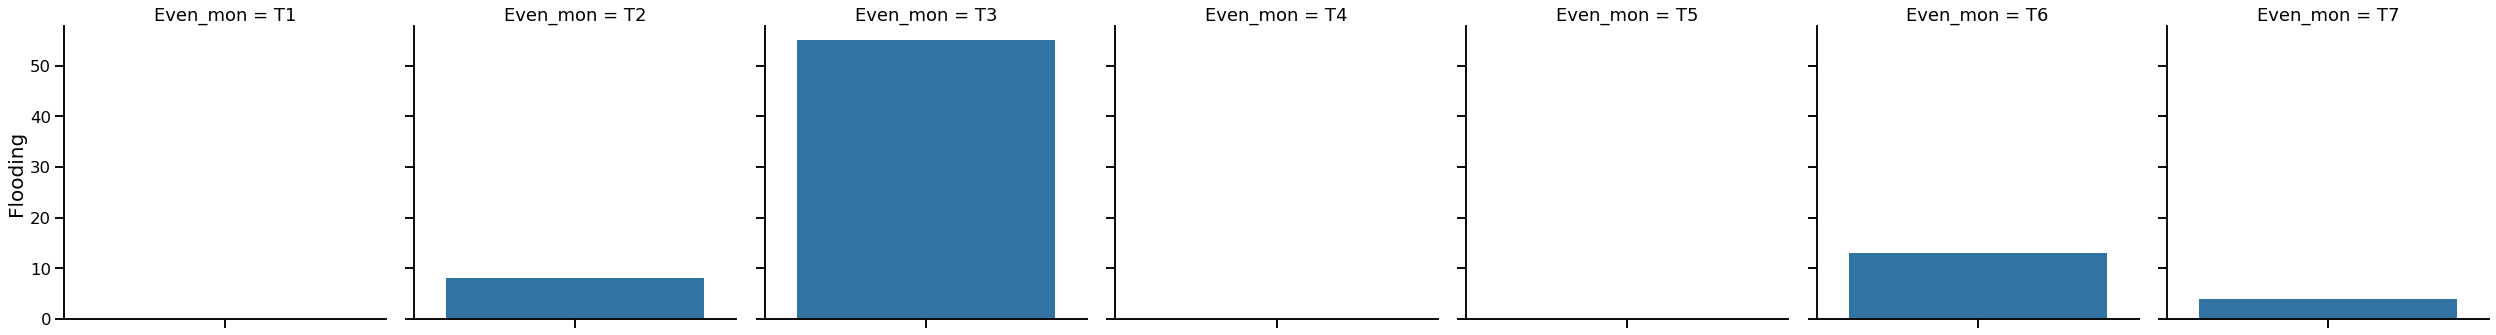

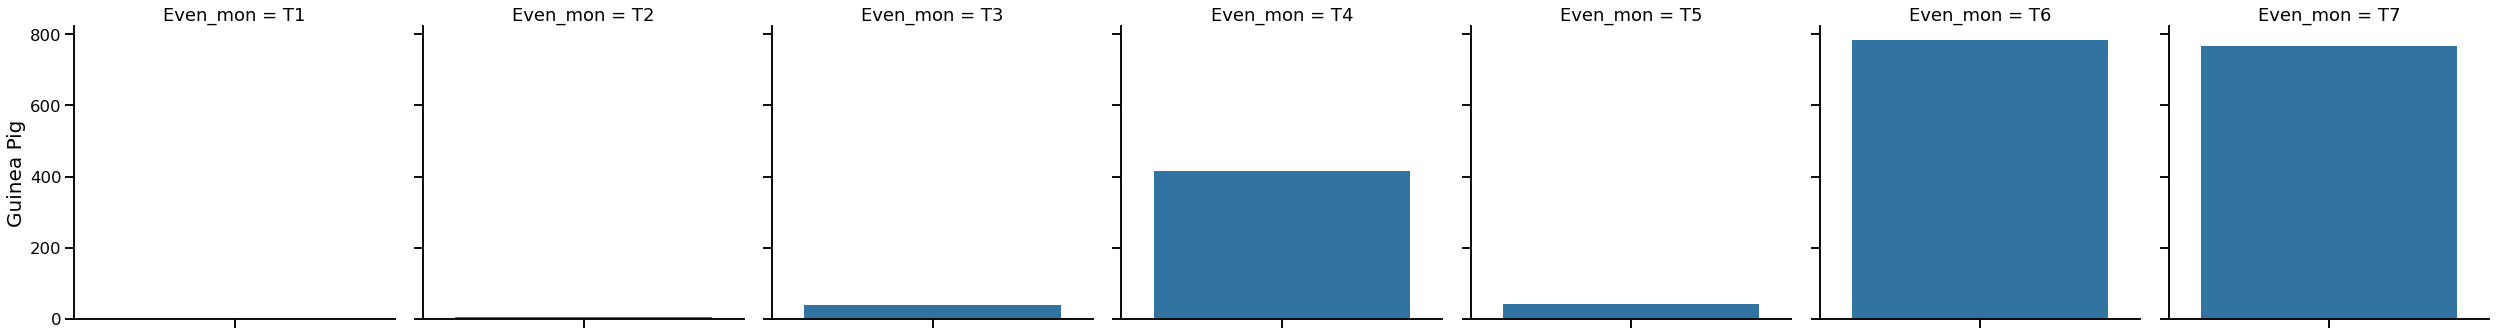

In [53]:
# Let's do it again without hue differentiation to see how overall populations were affected
affectations_per_period = reserve.groupby(['Even_mon'])[affectations].sum().reset_index()
for aff in affectations:
    fig = sns.catplot(y=aff, 
                      col='Even_mon', 
                      data=affectations_per_period, 
                      kind='bar')
    fig.set_axis_labels('', aff_dict[aff], fontsize=20)
# If the youngest plants were the least healthy we would expect to see peaks in periods T1, T3, and T5, which seems to be true.
# The main exception is low vigor, which seems to be cyclical?

It seems like overwhelmingly, the most recently planted individuals have the worst health. Apparently once a plant reaches a certain age or size, it stops being affected as heavily by health factors. Whether this is a trend onthe ground or sampling bias would need to be properly verified. The implication is, however, that if we account for a certain percentage of young plant deaths, the amount of plants that survive can be accounted for.

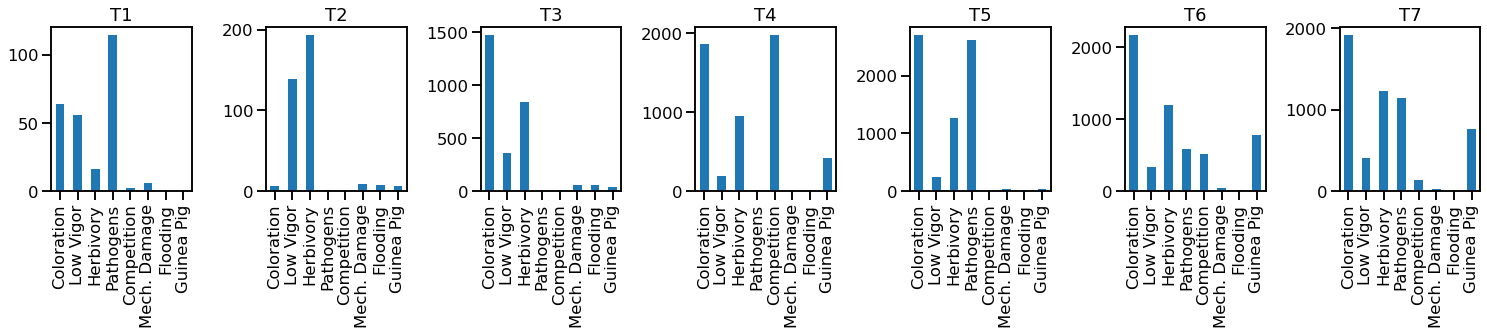

In [55]:
affectations_here = ['Coloracion', 'Vigor bajo', 'Herbivoria', 'Patogenos', 
                'Competencia', 'Daño mecanico', 'Anegamiento', 'Daño por Curi']
fig, ax = plt.subplots(1,7, figsize=(21,5))
col = 0
xticklabels = ['Coloration', 'Low Vigor', 'Herbivory', 'Pathogens', 
               'Competition','Mech. Damage', 'Flooding', 'Guinea Pig']
for value in reserve['Even_mon'].unique():
    df_affs = reserve[reserve['Even_mon'] == value][affectations_here]
    df_aff_sum = df_affs.sum()
    df_aff_sum.plot.bar(ax=ax[col])
    ax[col].set_xticklabels(xticklabels)
    ax[col].set_title(value)
    
    col += 1
fig.tight_layout()

# This shows the proportion of plants affected by each affectation, in a way that makes their
# relative effects easier to compare. Coloration and Herbivory seem like the most consistently
# important affectations, with Pathogens and Guinea Pig attacks becoming intermittently important.

Finally, is there a geographic component to the success of the plants?

Looking at a top-down distribution of effects can show how local conditions are affecting plant growth over time.

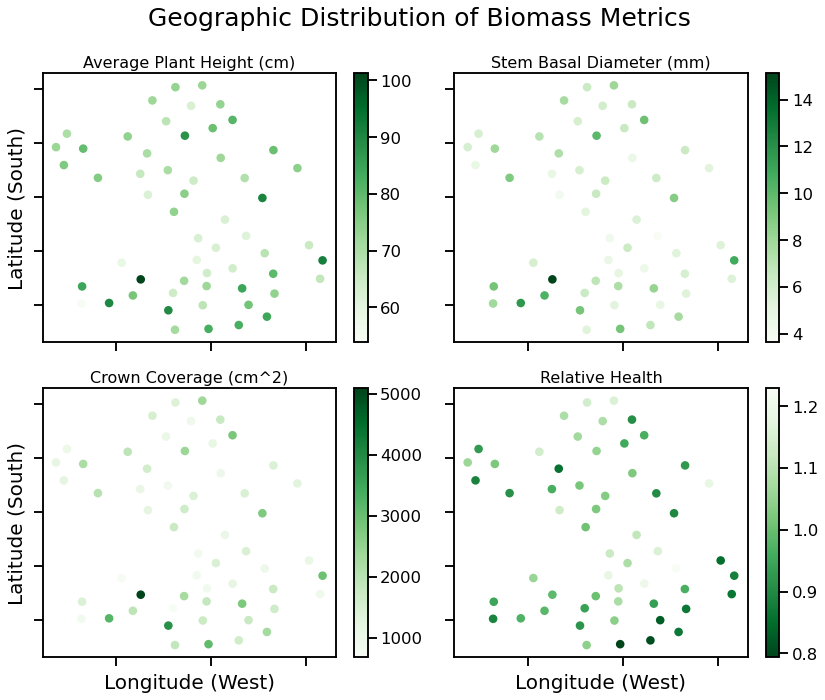

In [57]:
# Overall quantitative values
geo_quant = reserve.groupby(['COOR_ESTE', 'COOR_NORTE'])[['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']].mean().reset_index()


valores = {'Alt_Ind Promedio': 'Average Plant Height (cm)', 
           'DAB_prom': 'Stem Basal Diameter (mm)', 
           'Area_cop_ind': 'Crown Coverage (cm^2)',
           'Est_Fit_Ind': 'Relative Health'}
fig, ax = plt.subplots(2, 2, figsize=(12,10))
fig.tight_layout()
row = 0
col = 0
rep = 0
for valor in valores:
    if valor == 'Est_Fit_Ind':
        cmap = 'Greens_r'
    else:
        cmap = 'Greens'
    
    geo_quant.plot.scatter(x='COOR_ESTE', 
                           y='COOR_NORTE', 
                           xlabel=True, 
                           c=geo_quant[valor].array, 
                           colormap=cmap,
                           colorbar=True,
                           ax=ax[row,col],
                           s=50
                          )
    ax[row,col].set_yticklabels([])
    ax[row,col].set_xticklabels([])
    if row == 1:
        ax[row,col].set_xlabel('Longitude (West)', fontsize=20)
    else:
        ax[row,col].set_xlabel('')
    if col == 0:
        ax[row,col].set_ylabel('Latitude (South)', fontsize=20)
    else:
        ax[row,col].set_ylabel('')
    ax[row,col].set_title(valores[valor], fontsize=16)
    if rep == 1:
        col = 0
        row = 1
    else:
        col += 1
    rep += 1

plt.suptitle('Geographic Distribution of Biomass Metrics', fontsize=25)
fig.tight_layout()
    
#fig.savefig(figures+'Fig07 Geographic Distribution of Biomass Metrics', dpi=600, bbox_inches='tight', transparent=True)
# There appears to be a pattern where the biggest and healthiest plants are in the south of the plot.
# This correlation seems stronger with size than with health.

In [58]:
species = reserve['Especie'].unique()
species_list = []
for item in species:
    species_list.append(item)
to_remove = ['Hesperomeles sp.', 'Weinmannia sp.', 
                    'Ageratina sp.', 'Bucquetia glutinosa',
                   'Tibouchina lepidota', 'Ceroxylon alpinum', 
             'Myrsine dependens', 'Vallea stipularis',
            'Myrsine guianensis']#The least populous species so figures of these would be useless.
for item in to_remove:
    species_list.remove(item)

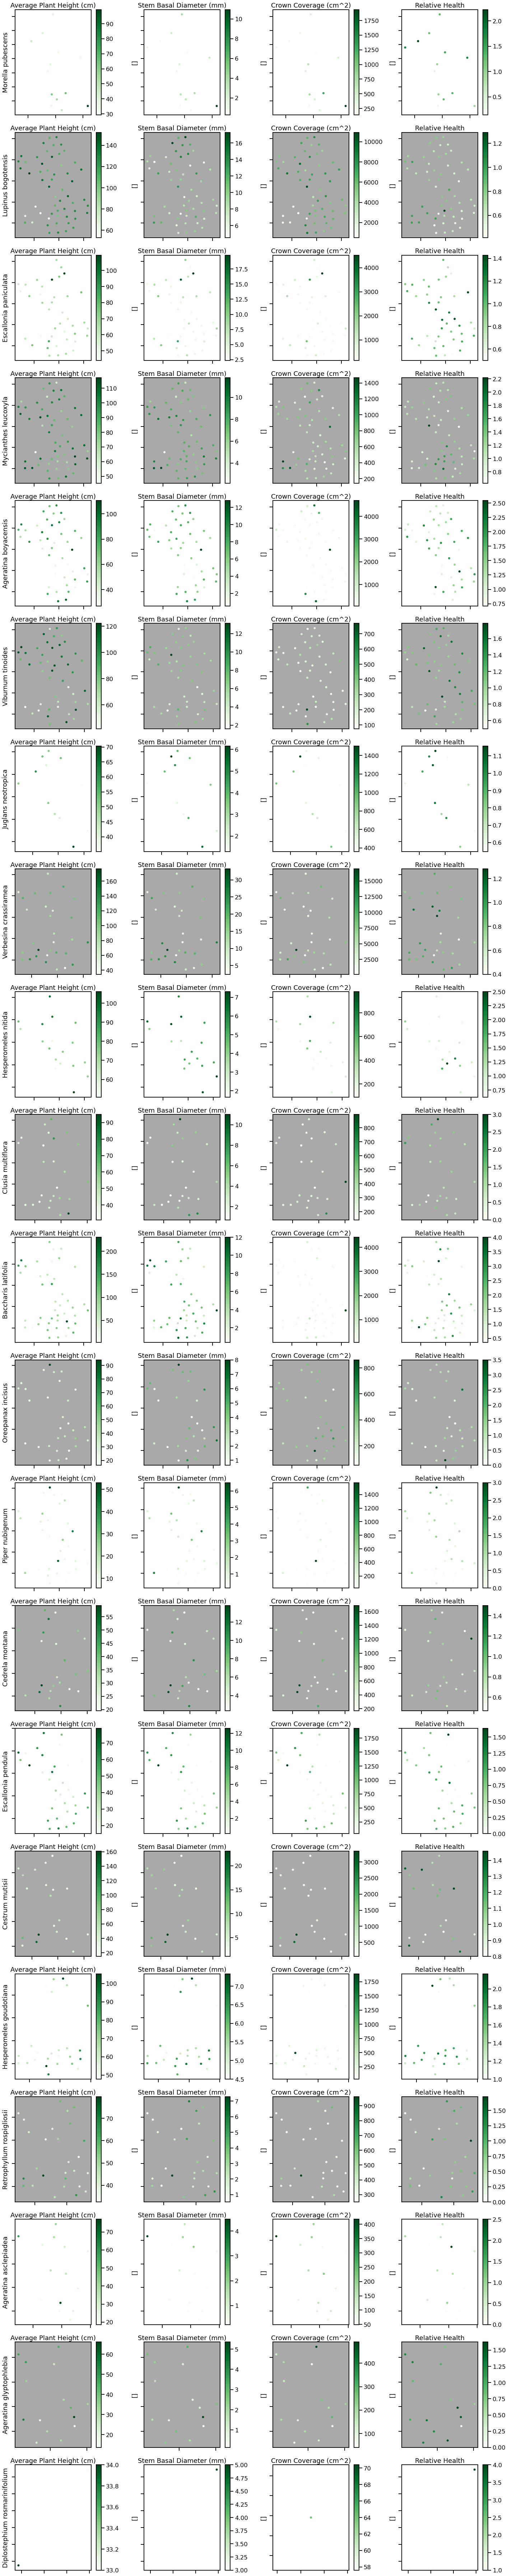

In [59]:
#Same as above but group by species.
geo_quant_spec = reserve.groupby(['Especie','COOR_ESTE', 'COOR_NORTE'])[['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']].mean().reset_index()



fig, axs = plt.subplots(nrows=len(species_list), ncols=4, figsize=(20, 100))
row = 0
for especie in species_list:
    
    col = 0
    for valor in valores:
        geo_quant_spec[geo_quant_spec['Especie'] == especie].plot(kind='scatter', 
                                                                  x='COOR_ESTE', 
                                                                  y='COOR_NORTE', 
                                                                  ax=axs[row, col], 
                                                                  xlabel=True, 
                                                                  c=geo_quant_spec[geo_quant_spec['Especie'] == especie][valor].array, 
                                                                  colorbar=True, 
                                                                  cmap='Greens',
                                                                  title=(valores[valor]))
        axs[row, col].set_xticklabels([])
        axs[row, col].set_yticklabels([])
        axs[row, col].set_xlabel('')
        if row%2 == 1:
            axs[row, col].patch.set_facecolor('darkgray')
        if col == 0:
            axs[row, col].set_ylabel(especie)
        else:
            axs[row, col].set_ylabel([])
        
        col += 1
    row += 1
fig.tight_layout()

# I'm including this chart because you can see size and health distributions per species.
# Some are more pronounced or useful than others, but since this would dramatically increase
# the scope of this analysis. I will simply leave it here instead of diving in.

In [60]:
geo_quant = reserve.groupby(['Especie','COOR_ESTE', 'COOR_NORTE'])[['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind', 'Sup_Ind']].mean().reset_index()
geo_quant

,Especie,COOR_ESTE,COOR_NORTE,Alt_Ind Promedio,DAB_prom,Area_cop_ind,Est_Fit_Ind,Sup_Ind
0,Ageratina asclepiadea,-73.910758,4.792586,56.768116,4.476087,417.304348,0.871795,0.847826
1,Ageratina asclepiadea,-73.910370,4.791235,18.583333,0.283333,90.250000,0.500000,0.500000
2,Ageratina asclepiadea,-73.910337,4.792404,24.214286,0.242857,126.607143,0.000000,0.500000
3,Ageratina asclepiadea,-73.910195,4.791861,35.698718,1.006410,166.788462,0.789474,0.678571
4,Ageratina asclepiadea,-73.910138,4.792568,38.688889,1.829630,204.907407,0.700000,0.714286
...,...,...,...,...,...,...,...,...
662,Viburnum tinoides,-73.909428,4.791240,67.785714,4.350794,163.547619,1.150000,0.937500
663,Weinmannia sp.,-73.910411,4.791085,43.357143,1.479762,472.607143,0.400000,0.625000
664,Weinmannia sp.,-73.909992,4.792638,42.475490,2.932353,357.484848,0.777778,0.794118
665,Weinmannia sp.,-73.909950,4.792362,39.791667,2.336310,225.092593,0.821429,0.903226


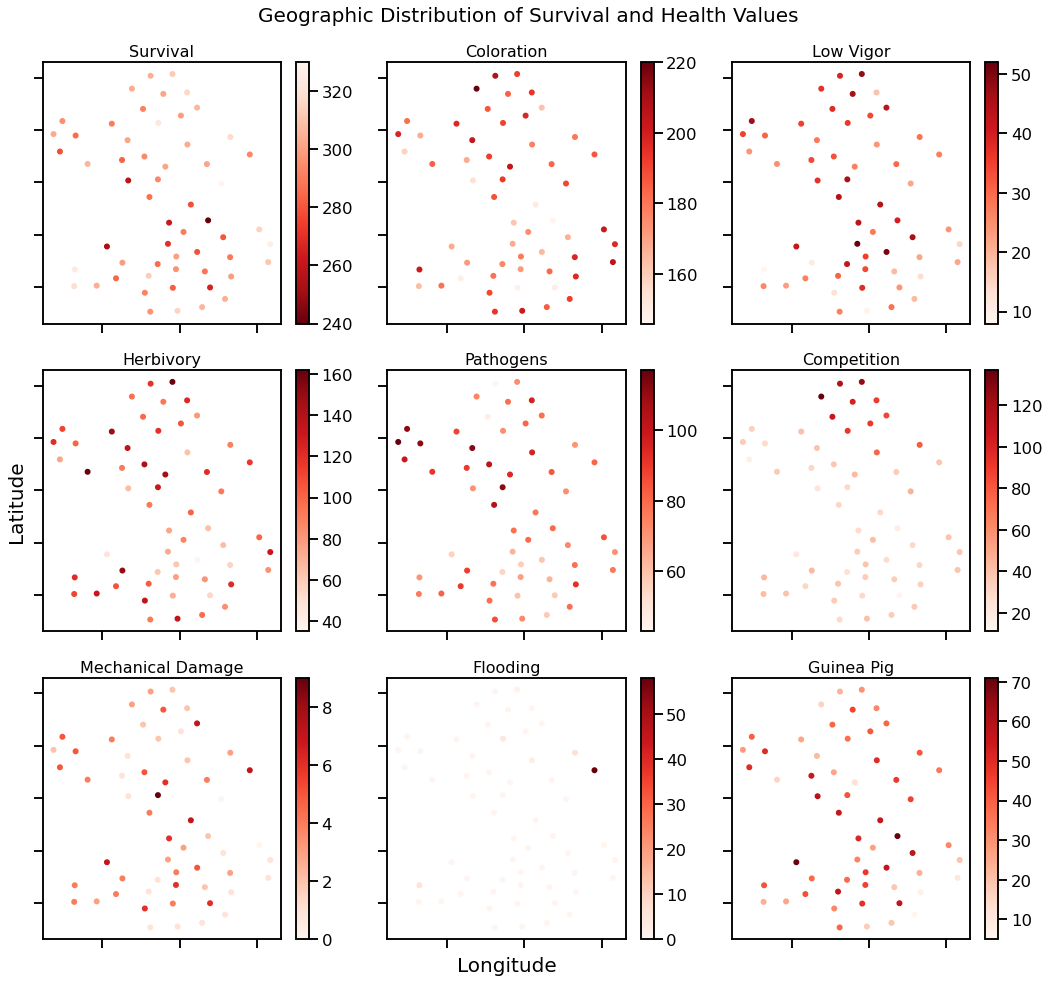

In [61]:
# Overall qualitative values
groups = ['No_Mod', 'COOR_ESTE', 'COOR_NORTE']
geo_qual = reserve.groupby(groups)[affectations].sum().reset_index()
#Multiply the values of Module 34 because it's 1/7th the size of the rest to normalize.
for aff in affectations:
    geo_qual.iloc[33, geo_qual.columns.get_loc(aff)] = geo_qual.iloc[33, geo_qual.columns.get_loc(aff)]*7


fig, ax = plt.subplots(3, 3, figsize=(15, 14))
fig.suptitle('Geographic Distribution of Survival and Health Values', fontsize=20)
row = 0
col = 0
rep = 0
for aff in aff_dict:
    if row == 0 and col == 0:
        cmap = 'Reds_r'
    else:
        cmap = 'Reds'
    geo_qual.plot(kind='scatter', 
                  x='COOR_ESTE', 
                  y='COOR_NORTE', 
                  c=geo_qual[aff].array, 
                  colorbar=True, 
                  cmap=cmap,
                  ax=ax[row, col])
    ax[row, col].set_title(aff_dict[aff], fontsize=16)
    ax[row, col].set_xticklabels([])
    ax[row, col].set_yticklabels([])
    if row == 2 and col == 1:
        ax[row, col].set_xlabel('Longitude', fontsize=20)
    else:
        ax[row, col].set_xlabel('')
    if col == 0 and row == 1:
        ax[row, col].set_ylabel('Latitude', fontsize=20)
    else:
        ax[row, col].set_ylabel('')
    if rep == 2 or rep == 5:
        row += 1
        col = 0
    else:
        col += 1
    rep += 1
fig.tight_layout()
#fig.savefig(figures+'Fig08 Geographic Distribution of Survival and Health Metrics', dpi=600, bbox_inches='tight', transparent=True)
# While some variables here like Mechanical Damage don't follow a pattern, and others like
# competition and flooding have very specific patterns, the rest of the variables instead seem
# to have a pattern where the edges show a stronger pattern, with the northern edge frequently
# showing the opposite effect as the rest of the edges.

Text(0.5, 0, 'Longitude')

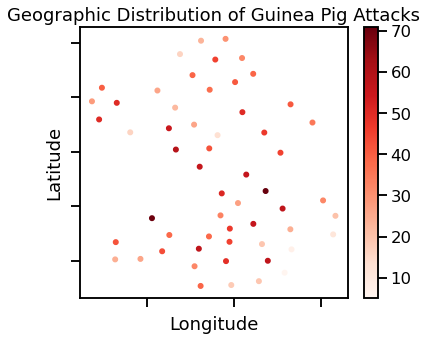

In [62]:
fig, ax = plt.subplots(figsize=(6,5))
geo_qual.plot(kind='scatter', 
              x='COOR_ESTE', 
              y='COOR_NORTE', 
              c=geo_qual['Daño por Curi'].array, 
              colorbar=True, 
              cmap='Reds',
              ax=ax)
ax.set_title('Geographic Distribution of Guinea Pig Attacks')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
#fig.savefig(figures+'Fig04 Geographic Distribution of Guinea Pig Attacks', dpi=600, bbox_inches='tight',transparent=True)

Text(0.5, 0, 'Longitude')

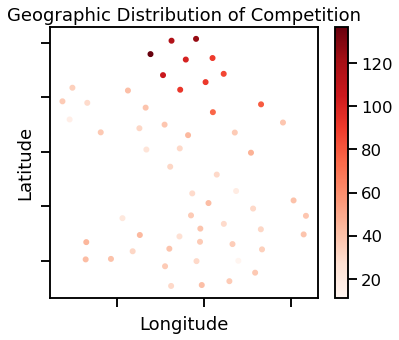

In [63]:
fig, ax = plt.subplots(figsize=(6,5))
geo_qual.plot(kind='scatter', 
              x='COOR_ESTE', 
              y='COOR_NORTE', 
              c=geo_qual['Competencia'].array, 
              colorbar=True, 
              cmap='Reds',
              ax=ax)
ax.set_title('Geographic Distribution of Competition')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
#fig.savefig(figures+'Fig12 Geographic Distribution of Competition', dpi=600, bbox_inches='tight', transparent=True)

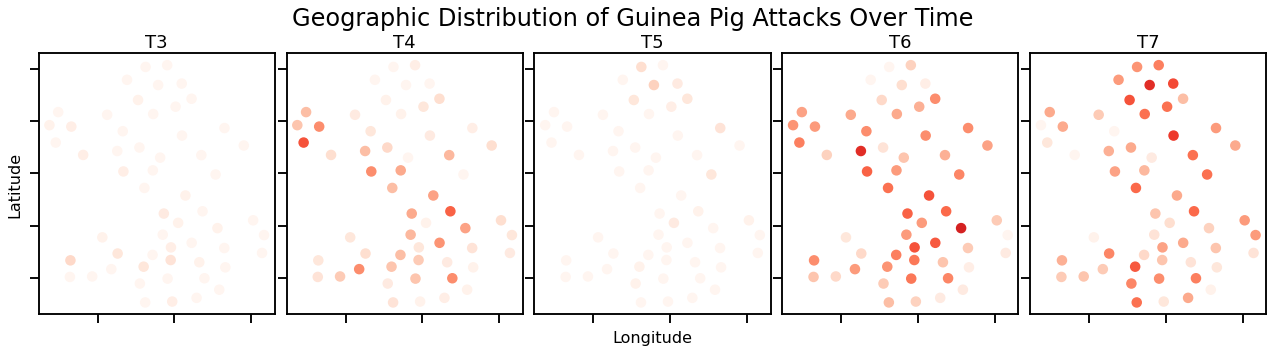

In [64]:
# Guinea Pig attacks are an easily identifiable form of herbivory that project managers
# Have deemed important to track. Here we will drill down into the matter.
curi_periodos = {}
mod_events = ['T3', 'T4', 'T5', 'T6', 'T7'] #T1 and T2 have no data
for time in mod_events:
    curi_periodos[time] = reserve[reserve['Even_mon'] == time]\
    .groupby(['COOR_ESTE', 'COOR_NORTE'])['Daño por Curi'].sum().reset_index()
fig, axs = plt.subplots(1,5, figsize =(22,5))
fig.suptitle('Geographic Distribution of Guinea Pig Attacks Over Time', fontsize=24)

p = 0
for mapa in curi_periodos:
    data = curi_periodos[mapa]
    x = 'COOR_ESTE'
    y = 'COOR_NORTE'

    
    plot = axs[p].scatter(x=x, 
                          y=y, 
                          data=data, 
                          c=data['Daño por Curi'].array, 
                          cmap ='Reds', 
                          vmin=0, 
                          vmax=46)
    axs[p].set_title(mapa)
    axs[p].set_xticklabels([])
    axs[p].set_yticklabels([])
    p += 1


axs[2].set_xlabel('Longitude', size = 16)
axs[0].set_ylabel('Latitude', size = 16)
plt.subplots_adjust(top = 0.85, wspace = 0.05)
#fig.savefig(figures+'Fig05 Geographic Distribution of Guinea Pig Attacks Over Time', dpi=600, bbox_inches='tight', transparent=True)
# There appears to be a cyclical nature to guinea pig attacks.

In [65]:
# A dict for charting the next figure which will show geographic distribution of
# guinea pig attacks over time, divided by plant generation
plant_events = ['T3', 'T5', 'T7']
nest = {}
for time in events:
    nest[time] = {}
    for plant in plant_events:
        nest[time][plant] = reserve[(reserve['Even_mon'] == time) & \
                                (reserve['Period planted'] == plant)]\
        .groupby(['COOR_ESTE', 'COOR_NORTE'])['Daño por Curi'].sum().reset_index()

for time in list(nest):
    for event in list(nest[time]):
        if nest[time][event].empty == True:
            nest[time].pop(event)

In [66]:
#find the value for vmax

for time in nest:
    for event in nest[time]:
        print(nest[time][event]['Daño por Curi'].max())

2
24
8
2
10
29
12
23
14


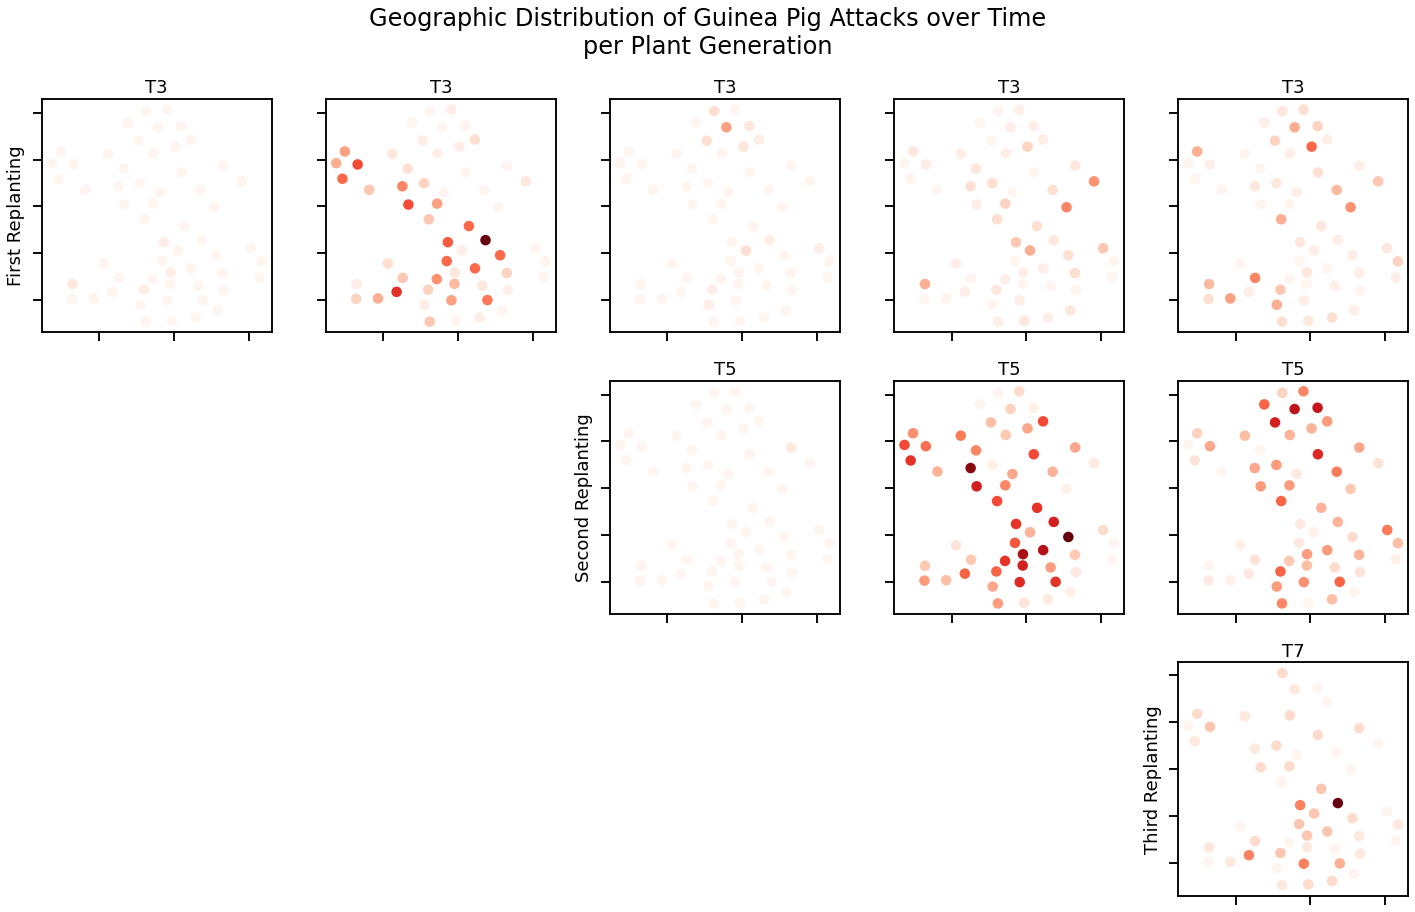

In [67]:
#A series of row/column tuples for the figure
coords = [(0,0), (0,1), (0,2), (1,2), (0,3), (1,3), (0,4), (1,4), (2,4)]
fig, axs = plt.subplots(3,5)
fig.set_figheight(13)
fig.set_figwidth(20)
fig.suptitle('Geographic Distribution of Guinea Pig Attacks over Time\nper Plant Generation', fontsize=24)

vmax_dict = {'T3':24,'T5':29,'T7':14}
cc = 0

for time in nest:
    for event in nest[time]:

        data = nest[time][event]
        x = 'COOR_ESTE'
        y = 'COOR_NORTE'

        plot = axs[coords[cc]].scatter(x=x, 
                                       y=y, 
                                       data=data, 
                                       c=data['Daño por Curi'].array, 
                                       cmap='Reds', 
                                       vmin=0, 
                                       vmax=vmax_dict[event])
        axs[coords[cc]].set_title(event)
        axs[coords[cc]].ticklabel_format(useOffset=False)
        axs[coords[cc]].tick_params(axis='x', labelsize=7)
        axs[coords[cc]].locator_params(axis='x', nbins=6)
        axs[coords[cc]].set_xticklabels([])
        axs[coords[cc]].set_yticklabels([])

        cc += 1

axs[2, 3].set_xlabel('Longitúd', size = 16)
axs[0, 0].set_ylabel('First Replanting')
axs[1, 2].set_ylabel('Second Replanting')
axs[2, 4].set_ylabel('Third Replanting')
empty = [(1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (2, 3)]
for tup in empty:
    axs[tup].axis('off')
fig.tight_layout()


#fig.savefig(figures+'Fig06 Geographic Distribution of Guinea Pig Attacks Over Time, by Time of Planting', dpi=600, bbox_inches='tight', transparent=True)
# Here we can see that between time planted and the next time we see a cohort,
# Guinea pigs will have attacked that cohort in preference over the others.
# This is either because the guinea pigs are mostly exhausting their perceived food
# Supply in our plantation, or because they simply prefer to eat young plants.

In [70]:
# Reproductive activity is an important part of ecological activity in the long term.
# These plants are young but any reproductive activity has been recorded in the comments
# as "Boton" (Buds), "Flor" (Flowers), or "Fruto" (Fruit).
reproductive1 = reserve[reserve['Observaciones_Crec'].str.contains('Boton') == True]
reproductive2 = reserve[reserve['Observaciones_Crec'].str.contains('Flor') == True]
reproductive3 = reserve[reserve['Observaciones_Crec'].str.contains('Fruto') == True]
reproductive = pd.concat([reproductive1, reproductive2, reproductive3], axis=0)
reproductive.groupby(['Even_mon']).count() 
# The result of this table is that
# Reproductive activity is definitely present but not measured consistently.
# Not worth graphing or even mentioning for now.

,Fecha,ID,Especie,No_Mod,No_Ind,Alt1_Ind,Alt2_Ind,Alt3_Ind,Alt_Ind Promedio,DAB1_Ind,...,Daño mecanico,Anegamiento,Planta no encontrada,Daño por Curi,Rebrotando,Observaciones_Sup,Period planted,Helada,COOR_ESTE,COOR_NORTE
Even_mon,,,,,,,,,,,,,,,,,,,,,
T4,8,8,8,8,8,8,4,4,8,8,...,8,8,8,8,8,0,8,0,8,8
T5,49,49,49,49,49,49,0,0,49,49,...,49,49,49,49,49,0,49,0,49,49


In [71]:
# Here we want to examine if species composition in the entire plot has changed over time
species_composition = reserve.groupby(['Even_mon','Especie'], as_index=False)['ID'].count()
species_composition = species_composition[species_composition['Especie'].str.contains(' sp.') == False]

In [72]:
describes = pd.DataFrame()
for time in events:
    describes[time] = species_composition[species_composition['Even_mon'] == time].describe()
describes.reset_index(inplace=True)

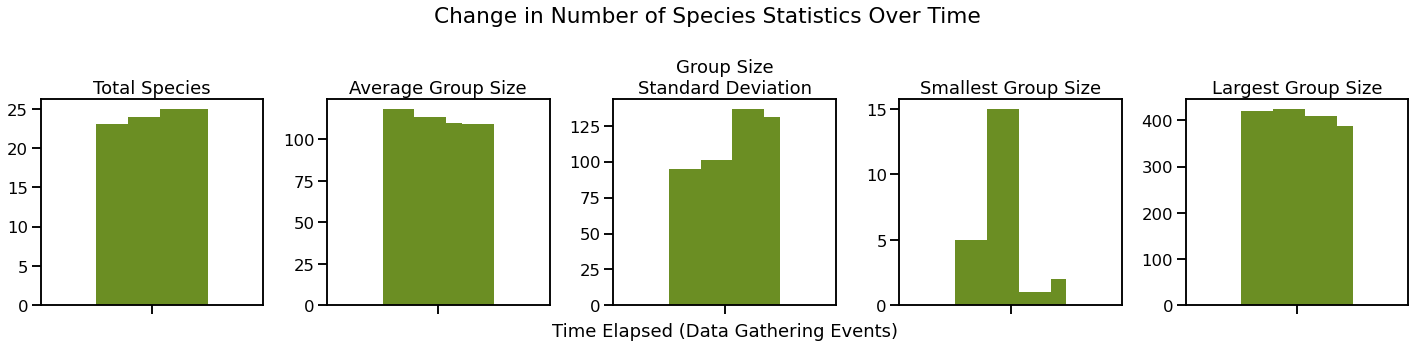

In [73]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
vals = {'count': 'Total Species',
       'mean': 'Average Group Size',
       'std': 'Group Size\nStandard Deviation',
       'min': 'Smallest Group Size',
       'max': 'Largest Group Size'}
col = 0
for val in vals:
    describes[describes['index'] == val].plot.bar(ax=ax[col], color='olivedrab')
    ax[col].set_title(vals[val])
    ax[col].set_xticklabels([])

    legend = ax[col].legend()
    legend.remove()
    col += 1
ax[2].set_xlabel('Time Elapsed (Data Gathering Events)')
fig.suptitle('Change in Number of Species Statistics Over Time')
fig.tight_layout()
#This chart shows that diversity in planted species has increased, but variance has also increased.

QUESTION 2 RECAP 
Plant health identified coloration, low vigor, and herbivory as important variables that
consistently affect our planted population. However, because coloration and low vigor
are variables that can have a great number of causes, herbivory was chosen to drill down
into.

Independently, geographic modelling of the plant variables demonstrates ecological interaction
with local conditions, and two different patterns were identified: In some cases plant
success is correlated with growth in the southern sector of the plot, and in other cases
plant growth is positively correlated with an apparent edge effect.

Combining these two methods, Guinea Pig attacks were chosen by management as an easily
tracked but important form of herbivory, and modeling their attacks shows they have a 
preference for younger plants, and appear to avoid the edges of the plot.

Reproductive activity in plants is present in the plants, but is sporadic.

Finally, plant diversity has actually increased over time, but representation of species
within the plantation has become increasingly unequal.

QUESTION 3: What can we do to improve our outcomes?
    -We want to improve plant survival first, then health, then diversity.
    -The things we can control are: The species planted, 
            locations planted, and treatments post-planting.
            
    We should therefore look into which species perform best or worst in various cases.

Text(0.5, 0.98, 'The 10 Most Succesful Species per Indicator')

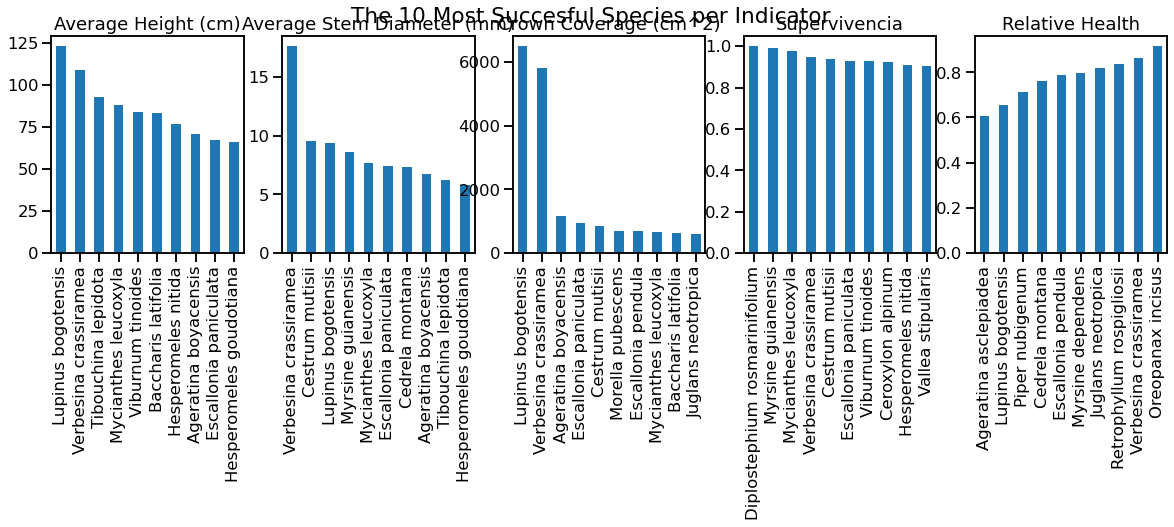

In [74]:
quants = ['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Sup_Ind', 'Est_Fit_Ind']
species_stats = reserve.groupby('Especie')[quants].mean().reset_index()
species_stats = species_stats[species_stats['Especie'].str.contains(' sp.') == False]
species_stats.drop(species_stats.loc[species_stats['Especie']=='Bucquetia glutinosa'].index, inplace=True) #This doesn't work
fig, ax = plt.subplots(1,5, figsize =( 20, 4))
values = {'Alt_Ind Promedio': 'Average Height (cm)', 
           'DAB_prom': 'Average Stem Diameter (mm)', 
           'Area_cop_ind': 'Crown Coverage (cm^2)',
           'Est_Fit_Ind': 'Relative Health',
           'Sup_Ind': 'Supervivencia'}
ncol = 0
for quant in quants:
    if quant == 'Est_Fit_Ind':
        tops = species_stats[['Especie', quant]].sort_values(by=quant, ascending=True).head(10)
    else:
        tops = species_stats[['Especie', quant]].sort_values(by=quant, ascending=False).head(10)
    tops.plot.bar(x='Especie', ax = ax[ncol])
    ax[ncol].set_title(values[quant])
    legend = ax[ncol].legend()
    legend.remove()
    ax[ncol].set_xlabel('')
    ncol += 1
plt.suptitle('The 10 Most Succesful Species per Indicator')
# Here we can identify some standout species like Verbesina crassiramea, Lupinus bogotensis, and
# Ageratina asclepiadea that perform well above all other species and could be used as the backbone
# of further planting in the region.

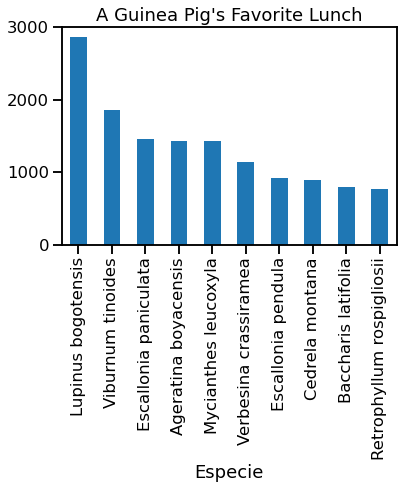

In [75]:
top5_group = reserve.groupby('Especie')[['Daño por Curi']].count()
especies_curi = top5_group['Daño por Curi'].sort_values(ascending=False).head(10)
especies_curi.plot(kind='bar')
plt.title("A Guinea Pig's Favorite Lunch");
#plt.savefig(figures+'Fig03 Guinea Pig Lunch', dpi=600, bbox_inches='tight', transparent=True)
# Here Lupinus bogotensis stands out as a favorite for guinea pigs. This may be survivorship bias.

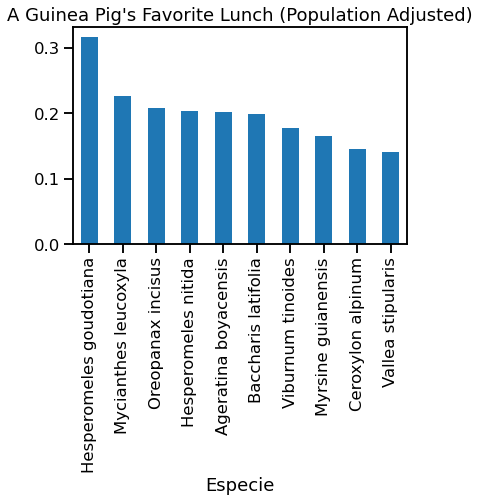

In [76]:
top_5_mean = reserve.groupby('Especie')[['Daño por Curi']].mean()
top_5_mean.drop(labels=['Ageratina sp.', 'Hesperomeles sp.'], inplace=True)
especies_curi = top_5_mean['Daño por Curi'].sort_values(ascending=False).head(10)
especies_curi.plot(kind='bar')
plt.title("A Guinea Pig's Favorite Lunch (Population Adjusted)");
#plt.savefig(figures+'Fig03 Guinea Pig Lunch (Adjusted)', dpi=600, bbox_inches='tight', transparent=True)
# Similarly here Hesperomeles goudotiana can be seen as wither the biggest attractor or
# the strongest survivor of guinea pig attacks.

Text(0.5, 0.98, 'The 10 Least Succesful Species per Indicator')

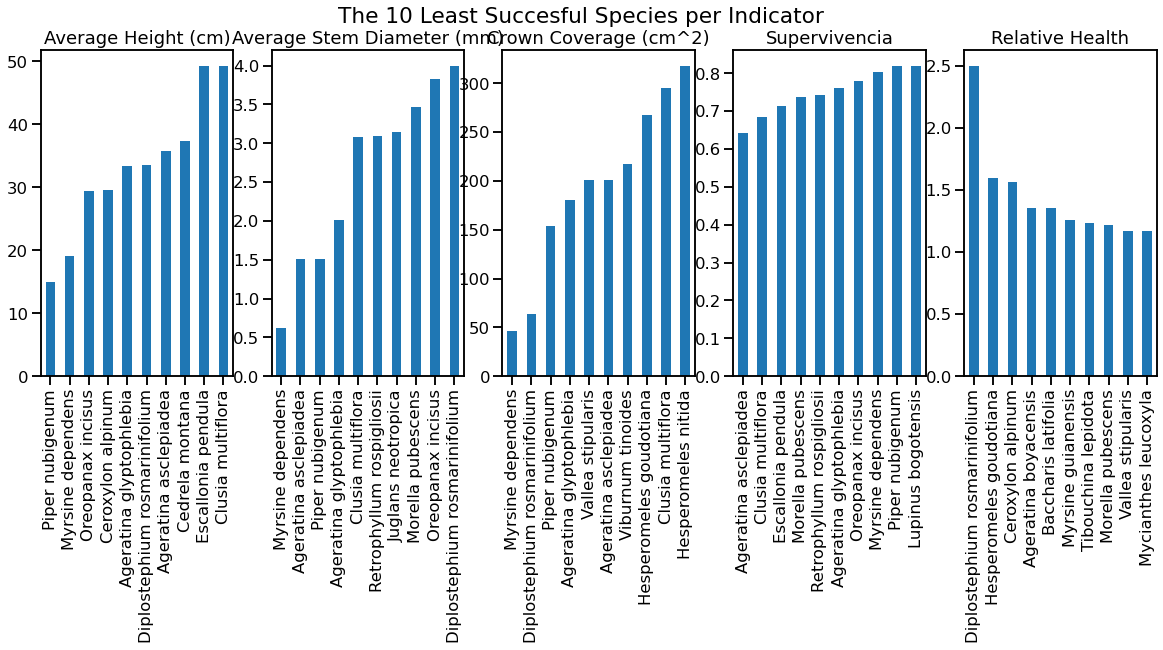

In [82]:
quants = ['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Sup_Ind', 'Est_Fit_Ind']
species_stats = reserve.groupby('Especie')[quants].mean().reset_index()
species_stats = species_stats[species_stats['Especie'].str.contains(' sp.') == False]
species_stats.drop(species_stats.loc[species_stats['Especie']=='Bucquetia glutinosa'].index, inplace=True) #This doesn't work
fig, ax = plt.subplots(1,5, figsize =( 20, 6))
values = {'Alt_Ind Promedio': 'Average Height (cm)', 
           'DAB_prom': 'Average Stem Diameter (mm)', 
           'Area_cop_ind': 'Crown Coverage (cm^2)',
           'Est_Fit_Ind': 'Relative Health',
           'Sup_Ind': 'Supervivencia'}
ncol = 0
for quant in quants:
    if quant == 'Est_Fit_Ind':
        tops = species_stats[['Especie', quant]].sort_values(by=quant, ascending=False).head(10)
    else:
        tops = species_stats[['Especie', quant]].sort_values(by=quant, ascending=True).head(10)
    tops.plot.bar(x='Especie', ax = ax[ncol])
    ax[ncol].set_title(values[quant])
    legend = ax[ncol].legend()
    legend.remove()
    ax[ncol].set_xlabel('')
    ncol += 1
fig.suptitle('The 10 Least Succesful Species per Indicator')

# Here we identify species like Piper nubigenum, Myrsine dependens, Diplostephium rosmarinifolium
# as species that should either be avoided or given special attention to when planted, as they
# underperform significantly compared to their peers. Ageratina asclepiadea on the other hand
# is consistently smaller but ranks very highly as a survivor.

In [83]:
#Find the most succesful species and the least succesful species
for quant in quants:
    print(species_stats[['Especie', quant]].sort_values(by=quant).head(10))
    print(species_stats[['Especie', quant]].sort_values(by=quant, ascending=False).head(10))

                          Especie  Alt_Ind Promedio
23                Piper nubigenum         14.924374
20              Myrsine dependens         19.026077
22              Oreopanax incisus         29.348780
7               Ceroxylon alpinum         29.547436
2         Ageratina glyptophlebia         33.420021
10  Diplostephium rosmarinifolium         33.500000
0           Ageratina asclepiadea         35.788419
6                 Cedrela montana         37.359454
12             Escallonia pendula         49.229803
9               Clusia multiflora         49.339676
                    Especie  Alt_Ind Promedio
17       Lupinus bogotensis        122.893339
27    Verbesina crassiramea        108.594990
25      Tibouchina lepidota         92.871283
19     Mycianthes leucoxyla         87.843069
28        Viburnum tinoides         83.641991
4       Baccharis latifolia         83.412297
14      Hesperomeles nitida         76.627166
1      Ageratina boyacensis         70.826449
11    Escallon

In [84]:
#This is measured in highest rates of survival
most_successful = ['Myrsine guianensis', 'Mycianthes leucoxyla', 'Verbesina crassiramea', 
                 'Cestrum mutisii', 'Escallonia paniculata', 'Viburnum tinoides', 
                 'Ceroxylon alpinum', 'Hesperomeles nitida']
least_successful = ['Ageratina asclepiadea', 
                  'Clusia multiflora', 'Escallonia pendula', 
                  'Morella pubescens', 'Retrophyllum rospigliosii', 
                  'Ageratina glyptophlebia', 'Oreopanax incisus', 'Myrsine dependens']
msdict = {}
for species in most_successful:
    msdict[species] = reserve[reserve['Especie'] == species]
lsdict = {}
for species in least_successful:
    lsdict[species] = reserve[reserve['Especie'] == species]

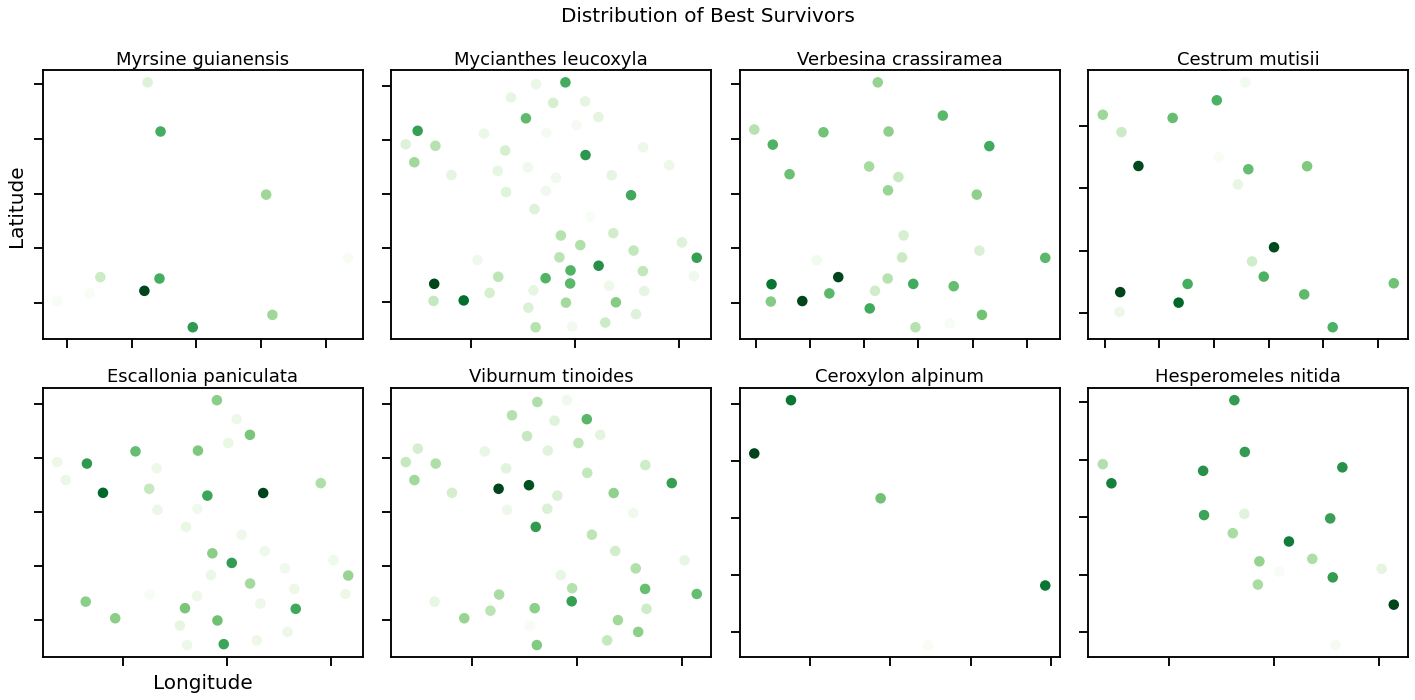

In [85]:
fig, axs = plt.subplots(2, 4)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Distribution of Best Survivors', fontsize = 20)
nrow = 0
ncol = 0
for species in msdict:
    data = msdict[species].groupby(['COOR_ESTE', 'COOR_NORTE'])['Sup_Ind'].sum().reset_index()
    x = 'COOR_ESTE'
    y = 'COOR_NORTE'

    plot = axs[nrow, ncol].scatter(x=x, y=y, data=data, c=data['Sup_Ind'].array, cmap='Greens')
    axs[nrow, ncol].set_title(species)
    axs[nrow, ncol].set_xticklabels('')
    axs[nrow, ncol].set_yticklabels('')
    if ncol == 3:
        nrow +=1
        ncol = 0
    else:
        ncol +=1
axs[0,0].set_ylabel('Latitude', fontsize = 20)
axs[1,0].set_xlabel('Longitude', fontsize = 20)
fig.tight_layout()
#fig.savefig(figures+'Fig09 Geographic Distribution of the Most Successful Plants', dpi=600, bbox_inches='tight', transparent=True)
# Some of these high survivorship plants (M. leucoxyla and V. crassiramea) 
# seem to prefer the southern edge of the plot.

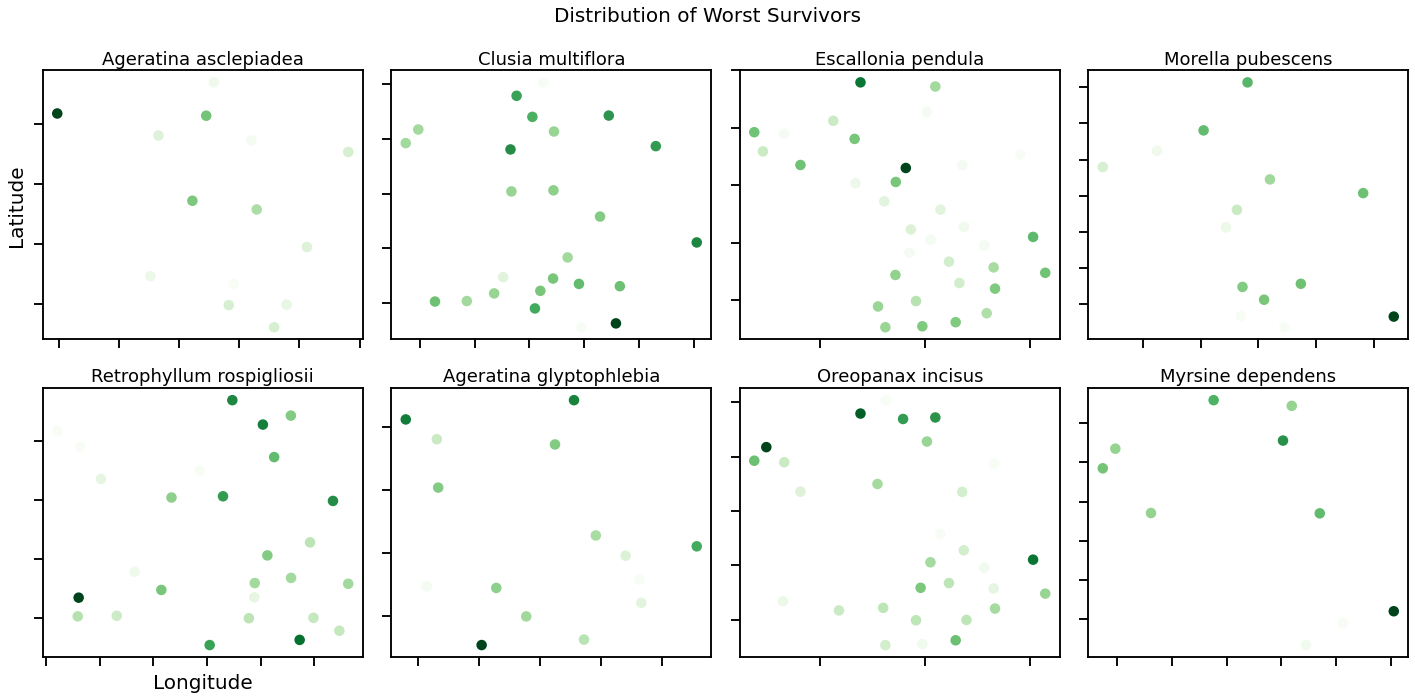

In [86]:
fig, axs = plt.subplots(2, 4)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Distribution of Worst Survivors', fontsize=20)
nrow = 0
ncol = 0
for species in lsdict:
    data = lsdict[species].groupby(['COOR_ESTE', 'COOR_NORTE'])['Sup_Ind'].sum().reset_index()
    x = 'COOR_ESTE'
    y = 'COOR_NORTE'

    plot = axs[nrow, ncol].scatter(x=x, y=y, data=data, c=data['Sup_Ind'].array, cmap='Greens')
    axs[nrow, ncol].set_title(species)
    axs[nrow, ncol].set_xticklabels('')
    axs[nrow, ncol].set_yticklabels('')
    if ncol == 3:
        nrow +=1
        ncol = 0
    else:
        ncol +=1
axs[0,0].set_ylabel('Latitude', fontsize = 20)
axs[1,0].set_xlabel('Longitude', fontsize = 20)
fig.tight_layout()
#fig.savefig(figures+'Fig10 Geographic Distribution of the Least Successful Plants', dpi=600, bbox_inches='tight', transparent=True)
# Patterns for low survivorship plants seem less obvious, but for C. multiflora seems to prefer
# the edge and O. incisus seems to prefer the northern edge.

QUESTION 3 RECAP
We identified species that grow well and survived and among those 3 species stand out.
    -These are Lupinus bogotensis, Verbesina crassiramea, and Ageratina asclepiadea
        
Similarly, among poorly performin plants the following species stand out.
    -Piper nubigenum, Myrsine dependens, Diplostephium rosmarinifolium.

Specifically under the lens of guinea pig attacks, Hesperomeles goudotiana is a species of
interest, either because it attracts guinea pigs disproportionately, or is best able to
survive their predation. Without knowing the exact cause of death of plants, it is difficult
to determine which is the reason.

The species that stand out above are simply the best or worst suited to current conditions.
As the plantation develops, the plants themselves will change the environment by 
causing more shade, developing root connections, and outcompeting other species.
This could in turn make underperforming plants more viable in the long run.

Part 6: Suggestions for Deployment

There are a handful of species that show significantly better performance compared to their
peers. Focusing our efforts on mainly planting those species should result in a decrease in
mortality as well as an increase in biomass and plant coverage. This will result in a
general decrease in species diversity in the plantation, but this is already ocurring, and
will instead allow us to focus our efforts and resources more efficiently. We can also help
mitigate this effect by selecting the species that appear to be performing better in specific
sub-areas in the plot.

Plant mortality is also highest in young plants. There are a number of factors involved, but
the distribution of grazing incidents caused by guinea pigs is one of the strongest predictors
of young plant mortality. There may be a long term benefit in intense protecion efforts on
the youngest plants, either by physical fencing or by chemical means that would have a negative
impact on local species interactions and wildlife populations in the short run, but could
result in a quicker establishment of the species we plant with a lower mortality, dramatically
reducing our long term costs.

Overall, the project appears to be moving towards its intended goals of establishing a
forest ecosystem similar to the one that surrounds it. Further study should focus on examining
the nature of the edge effects that we observe in the current data, as well as on changes
in populations of local flora and fauna. If the budget permits, the data appears to favor
short, intense actions of planting and maintenance rather than longer term but less intensive
approaches.